In [1]:
# Импортируем необходимые для работы библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
import re
import plotly.graph_objects as go
import math

# убираем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузим данные таблицы

data = pd.read_csv('data/data.csv')
data.head()

status private pool        propertyType               street    baths  \
0    Active          NaN  Single Family Home       240 Heather Ln      3.5   
1  for sale          NaN  single-family home    12911 E Heroy Ave  3 Baths   
2  for sale          NaN  single-family home    2005 Westridge Rd  2 Baths   
3  for sale          NaN  single-family home  4311 Livingston Ave  8 Baths   
4  for sale          NaN            lot/land       1524 Kiscoe St      NaN   

                                           homeFacts fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...  Gas Logs   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...       NaN   
2  {'atAGlanceFacts': [{'factValue': '1961', 'fac...       yes   
3  {'atAGlanceFacts': [{'factValue': '2006', 'fac...       yes   
4  {'atAGlanceFacts': [{'factValue': '', 'factLab...       NaN   

             city                                            schools  \
0  Southern Pines  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...   
1  Spokane Valley  [{'rating': ['4/10', 'None/10', '4/10'], 'data...   
2     Los Angeles  [{'rating': ['8/10', '4/10', '8/10'], 'data': ...   
3          Dallas  [{'rating': ['9/10', '9/10', '10/10', '9/10'],...   
4        Palm Bay  [{'rating': ['4/10', '5/10', '5/10'], 'data': ...   

         sqft zipcode    beds state stories mls-id PrivatePool       MlsId  \
0        2900   28387       4    NC     NaN    NaN         NaN      611019   
1  1,947 sqft   99216  3 Beds    WA     2.0    NaN         NaN   201916904   
2  3,000 sqft   90049  3 Beds    CA     1.0    NaN         yes  FR19221027   
3  6,457 sqft   75205  5 Beds    TX     3.0    NaN         NaN    14191809   
4         NaN   32908     NaN    FL     NaN    NaN         NaN      861745   

       target  
0    $418,000  
1    $310,000  
2  $2,895,000  
3  $2,395,000  
4      $5,000

In [ ]:
# Просмотрим структуру данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Мы имеем датасет об объектах недфижимости в США с 17 признаками строкового типа:

- **Status**  - информация о статусе объекта недвижимости в контексте продажи: (в продаже, продан, будет продаваться и т.д.),
- **private pool** - информация о наличии частного бассейна,
- **property type** - информация о виде собственности,
- **street** - адрес объекта недвижимости - улица, дом, подъезд и т.д.,
- **baths** - информация о наличии санузлов,
- **homeFacts** - признак с детальной информацией об объекте недвижимости, выполненный в виде вложенного списка и имеющий сложную структуру - из этого признака в  процессе изучения у нас должно получится несколько признаков,
- **fireplace** - информация о типе обогрева,
- **city** - город, в котором расположен объект,
- **schools** - информация об учебных заведениях вблизи объекта недвижимости аналогично признаку *homeFacts* выглядит в виде вложенного списка - из этого признака мы можем извлечь также несколько новых признаков,
- **sqft** - информация о площади объекта - судя по названию скорее всего в виде квадратных футов,
- **zipcode** - почтовый индекс,
- **beds**  - информация о койкоместах - на самом деле в процыессе изучения мы увидим, что этот признак также связан с площадью объекта,
- **state** - штат США, в которм расположен обїект,
- **stories** - информация о колличестве этажей,
- **mls-id** и **MlsId** - говорят нам о реэлтерах связанных с сделками по продаже данных объектов - один признак - идентификатор реэлтера, а другой - сделки,
- **PrivatePool** - еще один признак, раскрывающий информацию о бассейне,
- **target** - название говорит само за себя - это целевой признак - цена продаваемого объекта.

## Изучение признака **status**

In [3]:
# Создадим копию датасета для дальнейшей работы
data_2 = data.copy()

# смотрим на наличие пропусков
data_2['status'].isnull().sum()

39918

In [ ]:
# смотрим на уникальные значения
data_2['status'].unique().tolist()

['Active',
 'for sale',
 nan,
 'New construction',
 'New',
 'For sale',
 'Pending',
 'P',
 'Active/Contingent',
 'Pre-foreclosure / auction',
 ' / auction',
 'Under Contract',
 'Under Contract   Showing',
 'Pre-foreclosure',
 'Under Contract Backups',
 'foreclosure',
 'Active Under Contract',
 'Foreclosed',
 'Option Pending',
 'Under Contract Show',
 'for rent',
 'Auction',
 'A Active',
 'Contingent',
 'Pending   Continue To Show',
 'Price Change',
 'Back on Market',
 'Active Option',
 'Foreclosure',
 'recently sold',
 'Coming soon: Nov 21.',
 'Contingent Finance And Inspection',
 'Coming soon: Dec 4.',
 'P Pending Sale',
 'Coming soon: Nov 23.',
 'Active With Contingencies',
 'Pending Ab',
 'Pf',
 'Contingent Show',
 'Contract P',
 'Contingent Take Backup',
 'Apartment for rent',
 'Backup Contract',
 'Option Contract',
 'Pending Continue To Show',
 'pending',
 'Pending Inspection',
 'Active Option Contract',
 'C',
 'Auction - Active',
 'Contingent   Show',
 'Pi',
 'Due Diligence Perio

In [ ]:
# уникальное значение пропусков в столбце

data_2['status'].nunique()

159

In [4]:
# список всех возможных значений сохраняем в переменную status_values
status_values = data_2['status'].unique()  

# создаем словарь для перевода значений в группы для классификации статуса
status_groups = {
    'Sold': ['Sold', 'Closed', 'Listing Extended', 'C', 'Accept'],
    'On sale': ['Active', 'For sale', 'For rent', 'Auction', 'Contingent', 'Pending', 'New', 'Purchase','Ps', 'Activated', 'Continue', 'Contract', 'Nan'],
    'Will be on sale': ['Coming soon', 'Due Diligence Period', 'Contract Contingent On Buyer Sale', 'Pending', 'P', 'Auction', 'Foreclosure','Foreclosed', 'Pf', 'Backup', 'Option'],
    'Unclear status': []
}

# функция для группировки зачений признака status
def get_status_group(value):
    for group, keywords in sorted(status_groups.items(), key=lambda x: len(x[1]), reverse=True):
        if any(keyword.lower() in str(value).lower() for keyword in keywords):
            return group
    return 'Unclear status'

# применяем функцию к каждому значению в массиве уникальных значений
status_groups_array = [get_status_group(value) for value in status_values]

# создаем DataFrame с группами - сврего рода словарь перевода значения статуса в соответствующую группу
status_groups_df = pd.DataFrame(list(zip(status_values, status_groups_array)), columns=['status', 'status_rnk'])

# выводим результат
print(status_groups_df)

                                   status       status_rnk
0                                  Active          On sale
1                                for sale          On sale
2                                     NaN          On sale
3                        New construction          On sale
4                                     New          On sale
..                                    ...              ...
155                            Pending Sh          On sale
156                  Coming soon: Nov 25.  Will be on sale
157  Under Contract Taking Back Up Offers          On sale
158                                Backup  Will be on sale
159                  Coming soon: Dec 23.  Will be on sale

[160 rows x 2 columns]


In [5]:
# посмотрим более подробно вывод значений
 
status_groups_df.values.tolist()

[['Active', 'On sale'],
 ['for sale', 'On sale'],
 [nan, 'On sale'],
 ['New construction', 'On sale'],
 ['New', 'On sale'],
 ['For sale', 'On sale'],
 ['Pending', 'On sale'],
 ['P', 'Will be on sale'],
 ['Active/Contingent', 'On sale'],
 ['Pre-foreclosure / auction', 'On sale'],
 [' / auction', 'On sale'],
 ['Under Contract', 'On sale'],
 ['Under Contract   Showing', 'On sale'],
 ['Pre-foreclosure', 'Will be on sale'],
 ['Under Contract Backups', 'On sale'],
 ['foreclosure', 'Will be on sale'],
 ['Active Under Contract', 'On sale'],
 ['Foreclosed', 'Will be on sale'],
 ['Option Pending', 'On sale'],
 ['Under Contract Show', 'On sale'],
 ['for rent', 'On sale'],
 ['Auction', 'On sale'],
 ['A Active', 'On sale'],
 ['Contingent', 'On sale'],
 ['Pending   Continue To Show', 'On sale'],
 ['Price Change', 'Will be on sale'],
 ['Back on Market', 'Sold'],
 ['Active Option', 'On sale'],
 ['Foreclosure', 'Will be on sale'],
 ['recently sold', 'Sold'],
 ['Coming soon: Nov 21.', 'Will be on sale']

In [6]:
# проделаем процедуру перевода значения статуса в соответствующую группу в результате чего создадим новый признак status_pre_ranked

data_2['status_pre_ranked'] = data_2['status'].map(status_groups_df.set_index('status')['status_rnk'])

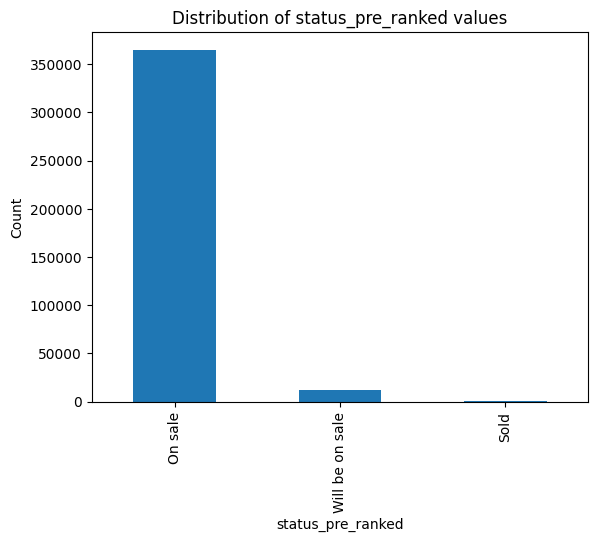

In [ ]:
# посмотрим визуально значения признака status_pre_ranked

data_2['status_pre_ranked'].value_counts().plot(kind='bar')
plt.title('Distribution of status_pre_ranked values')
plt.xlabel('status_pre_ranked')
plt.ylabel('Count')
plt.show()

In [7]:
# так как большая часть значений говорит нам о том, что объект недвижимости в процессе продажи  
# - целесообразно удалить столбцы с этой информацией из нашего датасета для построения модели в дальнейшем

data_2.drop(['status', 'status_pre_ranked'], axis=1, inplace=True)

## Изучение признака **private pool**

In [ ]:
# смотрим на наличие пропусков

data_2['private pool'].isnull().sum()

373004

In [ ]:
# смотрим уникальные значения

data_2['private pool'].unique()

array([nan, 'Yes'], dtype=object)

In [8]:
# проводим перекодировку значения Yes в 1

data_2['private pool'] = data_2['private pool'].map({'Yes': int(1)})

In [9]:
# проводим перекодировку пропусков в 0

data_2['private pool'] = data_2['private pool'].fillna(int(0))

In [10]:
data_2['private pool'].unique()

array([0., 1.])

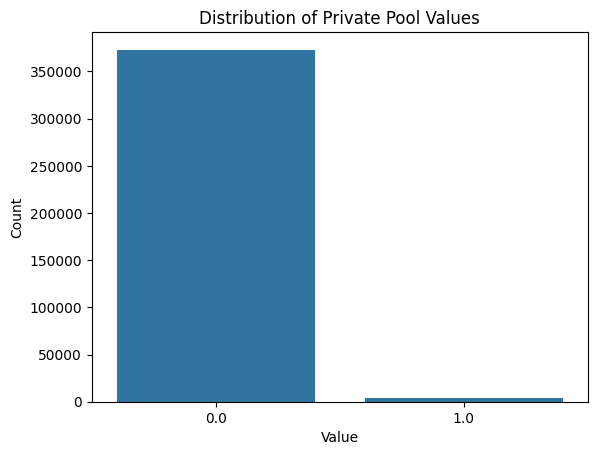

In [ ]:
# смотрим на распределение значений визуально

sns.countplot(x='private pool', data=data_2)
plt.title('Distribution of Private Pool Values')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

In [11]:
# аналогично прошлому признаку для нас этот признак несет мало информации и мы уго удаляем

data_2.drop(['private pool'], axis=1, inplace=True)

## Изучение признаков **street, zipcode, city**

In [ ]:
# смотрим уникальные значения признака street

data_2['street'].unique().tolist()

['240 Heather Ln',
 '12911 E Heroy Ave',
 '2005 Westridge Rd',
 '4311 Livingston Ave',
 '1524 Kiscoe St',
 '1624 S Newkirk St',
 '552 Casanova Ct ',
 '6094 Mingle Dr ',
 '11182 Owl Ave',
 '8612 Cedar Plains Ln',
 '14205 Roosevelt Ave #512',
 '4222 False Cypress Ln ',
 '16373 NW 16th St',
 '1538 Umpqua Dr',
 '15351 Falmouth Ave',
 '930 52nd St ',
 '2402 NW 22nd Rd ',
 '24 W 126th St ',
 '22702 Alderdale Ln',
 '1633 NE 15th St',
 '5930 E Avenue T2',
 '61425 Gosney Rd',
 '120 Jefferson Ave #12019 ',
 '4234 Orchard Pass Dr',
 '703 W Gemini Ln',
 '1755 18th St NW',
 '5755 SW 123 Ave ',
 '2104 Lou Ellen Ln #B',
 '9070 Southern Orchard Rd S',
 '430 Sterling Pl #1A',
 '2620 Alsace Ave',
 '6712 N Glen Ave',
 '2043 SE New York St',
 '3750 NE 170th St APT 407',
 '7314 Melvin Cir N',
 '423 N Church St #13-A',
 '2627 N Arthur Ave',
 '3360 SW 29th St',
 '5531 Eureka Springs Rd',
 '316 N Henderson Ave #4',
 '1104 Rotonda Cir ',
 '9418 Camino Santa Fe #19',
 'MLS #: STRI1057289',
 '2713 Oakmont Ct',
 

Признак **street** содержит данные об индексе и название улицы. Я считаю, что эта информация не влияет на стоимость недвижимости. Возможно если бы можно было каким-то образом вытянуть информацию о типе района города, но как мы видели в базе такой информации нет. При объеме базы около 370 тыс. записей - 337 тыс. уникальных названий улиц - сгруппировать по улицам тоже не получится.

In [ ]:
# колличество уникальных названия признака streets

data_2['street'].nunique()

337076

In [ ]:
# колличество уникальных названий признака zipcode - почтовый индекс

data_2['zipcode'].nunique()

4549

In [ ]:
# колличество уникальных названий признака city

data_2['city'].nunique()

2026

In [ ]:
# колличество уникальных названий признака state

data_2['state'].nunique()

39

In [ ]:
# колиичество уникальных сочетаний city - street в базе 

data_2.groupby('city')['street'].nunique()

city
                     24
--                    9
ALTAMONTE SPRINGS     2
ANN ARBOR             1
APOPKA                4
                     ..
Zanesville            4
Zapata                1
Zionsville            9
mcallen               1
the Hills             5
Name: street, Length: 2026, dtype: int64

In [ ]:
# количество уникальных значений в столбце street для каждой группы по столбцу city

data_2.groupby('city')['street'].nunique().sum()

338259

Номера почтовых индексов примерно в два раза больше числа городов (около 2-х тысяч). В среднем на один город в нашей базе приходится около 180 записей. Всего уникальных улиц в нашей базе (возможна может быть ситуация когда одинаковое название улицы может быть в нескольких городах) - 340 тысяч - сравнимо с базой - нет смысла выделять какие-то комбинации город - улица - для создания дополнительных признаков.

In [ ]:
# количество уникальных значений в столбце state

data_2['state'].unique()

array(['NC', 'WA', 'CA', 'TX', 'FL', 'PA', 'TN', 'IA', 'NY', 'OR', 'DC',
       'NV', 'AZ', 'GA', 'IL', 'NJ', 'MA', 'OH', 'IN', 'UT', 'MI', 'VT',
       'MD', 'CO', 'VA', 'KY', 'MO', 'WI', 'ME', 'MS', 'OK', 'SC', 'MT',
       'DE', 'Fl', 'BA', 'AL', 'OT', 'OS'], dtype=object)

In [12]:
# смотрим уникальные сочетания city - state

data_grouped_city_state = data_2.groupby('city')['state'].nunique()

# нас интересуют названия city встречающиеся в нескольких штатах

data_grouped_city_state = data_grouped_city_state[data_grouped_city_state > 1]

data_result = data_2.loc[data['city'].isin(data_grouped_city_state.index)]
data_result['counts'] = data_result['city'].map(data_grouped_city_state)

data_result['city'].unique().tolist()

['Dallas',
 'Houston',
 'Flushing',
 'Brooklyn',
 'Spring',
 'Jacksonville',
 'Charlotte',
 'Glendale',
 'Portland',
 'Woodway',
 'Cleveland',
 'Lakewood',
 'Boston',
 'Bloomington',
 'Columbus',
 'Westlake',
 'Bayside',
 'Nashville',
 'Hollywood',
 'Tamarac',
 'Parkland',
 'Pasadena',
 'South Pasadena',
 'Oakland',
 'Peoria',
 'Irving',
 'Gainesville',
 'Richmond',
 'Clarksville',
 'Wilmington',
 'Springfield',
 'Aurora',
 'Sun Valley',
 'Ashville',
 'Antioch',
 'Bellevue',
 'Santa Ana',
 'Ventura',
 'Midland',
 'Concord',
 'Clinton',
 'Roseville',
 'Arlington',
 'Lancaster',
 'Franklin',
 'Essex',
 'Thornton',
 'Englewood',
 'Brentwood',
 'Fairfield',
 'College Park',
 'Bakersfield',
 'ENGLEWOOD',
 'Venice',
 'Greenville',
 'Anderson',
 'Rockford',
 'Highland Park',
 'Independence',
 'Johnson City',
 'Westminster',
 'Burlington',
 'Summerfield',
 'Lookout Mountain',
 'Saginaw',
 'Wyoming',
 'Germantown',
 'Stockton',
 'Montgomery',
 'Westfield',
 'Garner',
 'Augusta',
 'Fairfax',
 'S

In [ ]:
# количество уникальных значений city встречающихся более чем в одном state

data_result['city'].nunique()

122

In [ ]:
# смотрим уникальные значения city встречающихся более чем в одном state - и сколько раз эти значения повторяются

print(data_result[['city', 'counts']].drop_duplicates().to_string(max_rows=None))

                                  city  counts
3                               Dallas       2
9                              Houston       2
10                            Flushing       2
15                            Brooklyn       2
23                              Spring       2
34                        Jacksonville       3
35                           Charlotte       5
49                            Glendale       8
53                            Portland       2
55                             Woodway       2
64                           Cleveland       9
69                            Lakewood       7
78                              Boston       2
92                         Bloomington       2
104                           Columbus       3
111                           Westlake       2
119                            Bayside       2
131                          Nashville       4
146                          Hollywood       2
169                            Tamarac       2
219          

Здесь мы видим, что значение city нельзя идентифицировать однозначно - одно и то же название города может встречаться в нескольких штатах. Таких названий городов у нас 122. Есть например такие названия, как Glendale (встречается в 8-ми штатах) и Charlotte (встречаются в 5-ти штатах).

Названия улицы, города и индекс не будут влиять на цену объекта недвижимости и мы удалим столбцы этих признаков из нашей базы.

In [13]:
# удаляем из датасета столбцы 'street', 'city', 'zipcode'

data_2.drop(['street', 'city', 'zipcode'], axis=1, inplace=True)

## Изучение признака **propertyType**

In [14]:
# смотрим уникальные значения признака propertyType

PropType = data['propertyType'].unique().tolist()
PropType

['Single Family Home',
 'single-family home',
 'lot/land',
 'townhouse',
 'Florida',
 nan,
 'Single Family',
 'coop',
 'English',
 '2 Story',
 'Townhouse',
 'multi-family',
 'Penthouse, Split-Level',
 'Multi-Family Home',
 'Condo',
 'condo',
 'Land',
 'Condo/Townhome/Row Home/Co-Op',
 ' ',
 'Detached, Two Story',
 '1 Story, Ranch',
 'Other Style',
 'Colonial',
 'Transitional',
 'High Rise',
 'mobile/manufactured',
 'Tri-Level, Northwestern Contemporary',
 'Detached, One Story',
 'Craftsman',
 'Single Detached, French',
 '1 Story, Traditional',
 'Single Detached, Traditional',
 'Federal',
 'Multi Family',
 'apartment',
 'Traditional',
 'Custom',
 'Cooperative',
 'Contemporary/Modern, Traditional',
 'Cape Cod, Contemporary, Florida, Key West',
 'Single Detached',
 'Mobile / Manufactured',
 'Contemporary/Modern',
 'Miscellaneous',
 'Mfd/Mobile Home',
 'Bungalow',
 '1 Story',
 'Spanish/Mediterranean',
 'Contemporary',
 'Multi-Level, Modern',
 'Condo/Unit',
 '2 Stories, Traditional',
 'Ranc

In [ ]:
# число уникалшьных значений propertyType

len(PropType)

1281

In [15]:
# находим 15 наиболее распространенных значений признака propertyType

# оставшиеся значения будем кодировать как other

top_15_values = data_2['propertyType'].value_counts().head(15).index.tolist()
data_2['propertyType'] = data_2['propertyType'].apply(lambda x: x if x in top_15_values else 'Other')

In [16]:
data_2['propertyType']

0         Single Family Home
1         single-family home
2         single-family home
3         single-family home
4                   lot/land
                 ...        
377180         Single Family
377181                 condo
377182    single-family home
377183                 Other
377184         Single Family
Name: propertyType, Length: 377185, dtype: object

In [17]:
# смотрим уникальные значения признака propertyType после перекодировки

data_2['propertyType'].unique()

array(['Single Family Home', 'single-family home', 'lot/land',
       'townhouse', 'Other', 'Single Family', 'coop', 'Townhouse',
       'multi-family', 'Condo', 'condo', 'Land',
       'Condo/Townhome/Row Home/Co-Op', 'High Rise', 'Multi Family',
       'Traditional'], dtype=object)

In [13]:
# смотрим на распределение значений признака propertyType - сколько раз каждок значение встречается в столбце

for i in data_2['propertyType'].unique():
    print(f"{i} - {data_2['propertyType'][data_2['propertyType'] == i].count()}")

Single Family Home - 31728
single-family home - 92206
lot/land - 20552
townhouse - 11464
Other - 68570
Single Family - 62869
coop - 3266
Townhouse - 6936
multi-family - 7900
Condo - 16561
condo - 25968
Land - 10934
Condo/Townhome/Row Home/Co-Op - 7701
High Rise - 1823
Multi Family - 2794
Traditional - 5913


In [18]:
# схожие лексические формы имеющие одинаковок смысловое значение объединяем

data_2['propertyType'] = data_2['propertyType'].replace({
    'single-family home': 'Single Family Home',
    'Single Family': 'Single Family Home',
    'multi-family': 'Multi Family',
    'condo': 'Condo'
})

In [19]:
# смотрим что у нас получилось после объединения названий признаков

for i in data_2['propertyType'].unique():
    print(f"{i} - {data_2['propertyType'][data_2['propertyType'] == i].count()}")

Single Family Home - 186803
lot/land - 20552
townhouse - 11464
Other - 68570
coop - 3266
Townhouse - 6936
Multi Family - 10694
Condo - 42529
Land - 10934
Condo/Townhome/Row Home/Co-Op - 7701
High Rise - 1823
Traditional - 5913


In [ ]:
# смотрим на наличие пропусков в перекодированном признаке propertyType

data_2['propertyType'].isna().sum()

0

In [20]:
# создаем 12 столбцов новых признаков через one hot encoding

data_2 = pd.get_dummies(data_2, columns=['propertyType'], dtype=int)

## Изучение признака **bath**

In [ ]:
# смотрим уникальные значения признака baths

data_2['baths'].unique().tolist()

['3.5',
 '3 Baths',
 '2 Baths',
 '8 Baths',
 nan,
 '2',
 '3',
 'Bathrooms: 2',
 '1,750',
 '4 Baths',
 '2 ba',
 'Bathrooms: 5',
 '1,000',
 '7 Baths',
 '2.0',
 '3.0',
 'Bathrooms: 1',
 '4.0',
 '2.1 Baths',
 '2.5 Baths',
 '1',
 'Bathrooms: 3',
 '4.5',
 '6 Baths',
 'Bathrooms: 4',
 '3 ba',
 '5',
 '2,500',
 '5.5 Baths',
 '1.0',
 '5 Baths',
 '1.5',
 '4',
 '~',
 '2.5',
 '4,000',
 '3.5 Baths',
 '2,000',
 '3,000',
 '8.0',
 '1 ba',
 '3.5 ba',
 '0',
 '5.0',
 '1,500',
 '7.0',
 '1,250',
 '9 Baths',
 '2,250',
 '6.0',
 '12 Baths',
 '5.5',
 '3,500',
 '1.5 Baths',
 '2,750',
 'Bathrooms: 6',
 '4.5 Baths',
 '750',
 '5.5+',
 '6',
 '10 Baths',
 '6 ba',
 'Bathrooms: 19',
 '10.0',
 '1.5 ba',
 '4 ba',
 '12 ba',
 '2.5+',
 '8',
 '7.5+',
 'Bathrooms: 10',
 '0 / 0',
 'Sq. Ft. ',
 '5 ba',
 '4.5+',
 '18 Baths',
 '-- baths',
 'Bathrooms: 7',
 '7',
 '18',
 '3.5+',
 '1.5+',
 '11 Baths',
 '5,000',
 '1.75 Baths',
 '9',
 '12.0',
 '1.1 Baths',
 '6.5',
 'Bathrooms: 8',
 '10',
 '19 Baths',
 'Bathrooms: 9',
 '16 Baths',
 '13

In [ ]:
# колличество уникальных значений признака baths

data_2['baths'].nunique()

229

In [21]:
# Выводим все виды значений data_2['baths'] имеющие в своем составе символ ' / '

print(data_2[data_2['baths'].apply(lambda x: ' / ' in str(x) if not pd.isnull(x) else False)]['baths'].unique())

['0 / 0' '1-0 / 1-0 / 1' '116 / 116 / 116' '3-1 / 2-2' '1 / 1 / 1 / 1'
 '2-1 / 2-1 / 1-1 / 1-1' '1 / 1-0 / 1-0 / 1-0']


In [22]:
# Считаем сколько раз встречаются в столбце значения содержащие знак ' / '

Mask_baths = data_2[data_2['baths'].apply(lambda x: ' / ' in str(x) if not pd.isnull(x) else False)]['baths'].unique()

for i in Mask_baths:
    print(f"{i} - {data_2['baths'][data_2['baths'] == i].count()}")

0 / 0 - 63
1-0 / 1-0 / 1 - 1
116 / 116 / 116 - 1
3-1 / 2-2 - 1
1 / 1 / 1 / 1 - 1
2-1 / 2-1 / 1-1 / 1-1 - 1
1 / 1-0 / 1-0 / 1-0 - 1


In [ ]:
# Посмотрим детально все строки датасета с вышенайденными значениями

data_2[data_2['baths'] == '1-0 / 1-0 / 1']

baths                                          homeFacts  \
24724  1-0 / 1-0 / 1  {'atAGlanceFacts': [{'factValue': '1920', 'fac...   

      fireplace                                            schools  sqft beds  \
24724       NaN  [{'rating': ['6', '5', '3', '4', '5', 'NR', 'N...  2932  3.0   

      state stories mls-id PrivatePool  ... propertyType_High Rise  \
24724    TN    2.00    NaN         NaN  ...                      0   

      propertyType_Land  propertyType_Multi Family  propertyType_Other  \
24724                 0                          0                   1   

       propertyType_Single Family Home  propertyType_Townhouse  \
24724                                0                       0   

       propertyType_Traditional  propertyType_coop  propertyType_lot/land  \
24724                         0                  0                      0   

       propertyType_townhouse  
24724                       0  

[1 rows x 24 columns]

In [46]:
data_2[data_2['baths'] == '116 / 116 / 116']

baths                                          homeFacts  \
63514  116 / 116 / 116  {'atAGlanceFacts': [{'factValue': '2019', 'fac...   

      fireplace                                            schools   sqft  \
63514       NaN  [{'rating': ['1', 'NR', '3', '1', '2', '1', 'N...  99999   

      beds state stories mls-id PrivatePool  ... propertyType_High Rise  \
63514  NaN    TN    2.00    NaN         NaN  ...                      0   

      propertyType_Land  propertyType_Multi Family  propertyType_Other  \
63514                 0                          0                   1   

       propertyType_Single Family Home  propertyType_Townhouse  \
63514                                0                       0   

       propertyType_Traditional  propertyType_coop  propertyType_lot/land  \
63514                         0                  0                      0   

       propertyType_townhouse  
63514                       0  

[1 rows x 24 columns]

In [47]:
data_2[data_2['baths'] == '0 / 0']

baths                                          homeFacts fireplace  \
2126    0 / 0  {'atAGlanceFacts': [{'factValue': '', 'factLab...       NaN   
2698    0 / 0  {'atAGlanceFacts': [{'factValue': '', 'factLab...       NaN   
2878    0 / 0  {'atAGlanceFacts': [{'factValue': '', 'factLab...       NaN   
9372    0 / 0  {'atAGlanceFacts': [{'factValue': '1970', 'fac...       NaN   
22677   0 / 0  {'atAGlanceFacts': [{'factValue': '', 'factLab...       NaN   
...       ...                                                ...       ...   
348391  0 / 0  {'atAGlanceFacts': [{'factValue': '', 'factLab...       NaN   
359861  0 / 0  {'atAGlanceFacts': [{'factValue': '1915', 'fac...       NaN   
366061  0 / 0  {'atAGlanceFacts': [{'factValue': '', 'factLab...       NaN   
372996  0 / 0  {'atAGlanceFacts': [{'factValue': '', 'factLab...       NaN   
375090  0 / 0  {'atAGlanceFacts': [{'factValue': '', 'factLab...       NaN   

                                                  schools  sqft beds state  \
2126    [{'rating': ['7', '6', '5', '5', '4', '6'], 'd...  2241    4    FL   
2698    [{'rating': [], 'data': {'Distance': [], 'Grad...     0  0.0    GA   
2878    [{'rating': ['9', '7', '8', '7', '9', 'NR'], '...     0  0.0    GA   
9372    [{'rating': ['3', '3', 'NR', 'NR'], 'data': {'...  1248  0.0    MI   
22677   [{'rating': ['7', '7', '8', '9', '9', 'NR'], '...     0  0.0    GA   
...                                                   ...   ...  ...   ...   
348391  [{'rating': ['7', '7', '8', '9', '9'], 'data':...     0  0.0    GA   
359861  [{'rating': ['6', '5', '1', '3', '2', '2', 'NR...  3043  0.0    OH   
366061  [{'rating': [], 'data': {'Distance': [], 'Grad...     0  0.0    GA   
372996  [{'rating': [], 'data': {'Distance': [], 'Grad...     0  0.0    GA   
375090  [{'rating': ['7', '7', '8', '9', '9'], 'data':...     0  0.0    GA   

       stories mls-id PrivatePool  ... propertyType_High Rise  \
2126       NaN    NaN         NaN  ...                      0   
2698       NaN    NaN         NaN  ...                      0   
2878       NaN    NaN         NaN  ...                      0   
9372     Ranch    NaN         NaN  ...                      0   
22677      NaN    NaN         NaN  ...                      0   
...        ...    ...         ...  ...                    ...   
348391     NaN    NaN         NaN  ...                      0   
359861    2.00    NaN         NaN  ...                      0   
366061     NaN    NaN         NaN  ...                      0   
372996     NaN    NaN         NaN  ...                      0   
375090     NaN    NaN         NaN  ...                      0   

       propertyType_Land  propertyType_Multi Family  propertyType_Other  \
2126                   0                          0                   0   
2698                   1                          0                   0   
2878                   1                          0                   0   
9372                   0                          0                   0   
22677                  1                          0                   0   
...                  ...                        ...                 ...   
348391                 1                          0                   0   
359861                 0                          0                   0   
366061                 1                          0                   0   
372996                 1                          0                   0   
375090                 1                          0                   0   

        propertyType_Single Family Home  propertyType_Townhouse  \
2126                                  1                       0   
2698                                  0                       0   
2878                                  0                       0   
9372                                  1                       0   
22677                                 0                       0   
...                                 ...           

In [23]:
# перекодируем вышенайденные записи в цифру - число санузлов

data_2['baths'] = data_2['baths'].apply(lambda x: {
    '0 / 0': 0,
    '1-0 / 1-0 / 1': 1,
    '116 / 116 / 116': 116,
    '3-1 / 2-2': 7,
    '1 / 1 / 1 / 1': 4,
    '2-1 / 2-1 / 1-1 / 1-1': 6,
    '1 / 1-0 / 1-0 / 1-0': 1,
    '1-2 Baths': 2
}.get(x, x))

In [24]:
# обрабатываем значения признака bath так, чтобы остались только цифровые составляющие

data_2['baths'] = data_2['baths'].str.lower().str.replace('sq. ft.', '').str.replace('semi mod', '').str.replace('semimod', '').str.replace('bathrooms', '').str.replace('baths', '').str.replace('ba', '').str.replace('+', '').str.replace('~', '').str.replace(' ', '').str.replace(':', '').str.replace('—', '').str.replace('-', '').str.replace(',', '.')

In [ ]:
# смотрим что у нас получилось

data_2['baths'].unique().tolist()

['3.5',
 '3',
 '2',
 '8',
 nan,
 '1.750',
 '4',
 '5',
 '1.000',
 '7',
 '2.0',
 '3.0',
 '1',
 '4.0',
 '2.1',
 '2.5',
 '4.5',
 '6',
 '2.500',
 '5.5',
 '1.0',
 '1.5',
 '',
 '4.000',
 '2.000',
 '3.000',
 '8.0',
 '0',
 '5.0',
 '1.500',
 '7.0',
 '1.250',
 '9',
 '2.250',
 '6.0',
 '12',
 '3.500',
 '2.750',
 '750',
 '10',
 '19',
 '10.0',
 '7.5',
 '18',
 '11',
 '5.000',
 '1.75',
 '12.0',
 '1.1',
 '6.5',
 '16',
 '13',
 '14',
 '9.0',
 '8.5',
 '17',
 '241',
 '16.0',
 '10.5',
 '7.500',
 '11.0',
 '20',
 '40',
 '14.0',
 '2.75',
 '24',
 '22.0',
 '0.00',
 '2.25',
 '3.1',
 '3.25',
 '22',
 '32',
 '18.0',
 '0.0',
 '27',
 '26',
 '20.0',
 '9.5',
 '15',
 '35',
 '3.75',
 '29',
 '21',
 '5.2',
 '14.5',
 '76',
 '13.0',
 '15.0',
 '23',
 '3.3',
 '43',
 '1.25',
 '34',
 '2.2',
 '55.0',
 '25',
 '12.5',
 '44',
 '0.5',
 '4.25',
 '4.75',
 '0.75',
 '4.1',
 '5.25',
 '41.0',
 '1.8',
 '36',
 '30',
 '24.0',
 '23.0',
 '28',
 '2.8',
 '34.0',
 '64.0',
 '11.5',
 '39',
 '30.0',
 '17.0',
 '42',
 '3.2',
 '60',
 '6.75',
 '68',
 '44.0

In [25]:
# Далее преобразуем значение признака baths следующим образом: 
# Если строка содержит только цифры и точку (x.replace('.', '', 1).isdigit()), то:
# - Преобразует строку в число с плавающей точкой (float(x)).
# - Округляет число до ближайшего целого числа в большую сторону (math.ceil()).
# - Если строка не содержит только цифры и точку, то оставляет значение без изменений.
# Если значение в столбце baths не является строкой, то оставляет значение без изменений.

data_2['baths'] = data_2['baths'].apply(lambda x: math.ceil(float(x)) if isinstance(x, str) and x.replace('.', '', 1).isdigit() else x)

In [26]:
#  Преобразуем столбец baths в датасете data_2 в числовой тип с помощью функции pd.to_numeric().
# Параметр errors='coerce' указывает, что если значение в столбце baths не может быть преобразовано в число, то оно должно быть заменено на значение NaN (Not a Number).
# В результате получается новый столбец baths, в котором все значения, которые могут быть преобразованы в числа, преобразуются в числовой тип, а остальные значения заменяются на NaN.

data_2['baths'] = pd.to_numeric(data_2['baths'], errors='coerce')

# заменяем все пропущенные значения в столбце baths - медианным значением

data_2['baths'] = data_2['baths'].fillna(data_2['baths'].median())

# Преобразуем все значения baths к целому типу

data_2['baths'] = data_2['baths'].astype(int)

In [27]:
# Смотрим уникальные значения столбца baths, которые у нас получились

data_2['baths'].unique()

array([  4,   3,   2,   8,   5,   1,   7,   6,   0,   9,  12, 750,  10,
        19,  18,  11,  16,  13,  14,  17, 241,  20,  40,  24,  22,  32,
        27,  26,  15,  35,  29,  21,  76,  23,  43,  34,  55,  25,  44,
        41,  36,  30,  28,  64,  39,  42,  60,  68])

## Изучение признака **homeFacts**

Значения признака  homeFacts имеют одинаковую структуру - это словарь с ключом 'atAGlanceFacts' у которого значение представляет из себя список словарей со следующими значениями:

- 'factValue': значение подпризнака Year built, 'factLabel': 'Year built' - название подпризнака;
- 'factValue': значение подпризнака Remodeled year, 'factLabel': 'Remodeled year' - название подпризнака;
- 'factValue': значение подпризнака Heating, 'factLabel'- название подпризнака;
- 'factValue': значение подпризнака Cooling, 'factLabel'- название подпризнака;
- 'factValue': значение подпризнака Parking, 'factLabel'- название подпризнака;
- 'factValue': значение подпризнака lotsize, 'factLabel'- название подпризнака;
- 'factValue': 'значение подпризнака Price/sqft, 'factLabel'- название подпризнака.

In [ ]:
# Смотрим значение 'homeFacts' в нулевой строке

data_2['homeFacts'][0]

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"

"{'atAGlanceFacts':
     [  {'factValue': '2019', 'factLabel': 'Year built'}, 
        {'factValue': '', 'factLabel': 'Remodeled year'},
        {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'},
        {'factValue': '', 'factLabel': 'Cooling'},
        {'factValue': '', 'factLabel': 'Parking'},
        {'factValue': None, 'factLabel': 'lotsize'},
        {'factValue': '$144', 'factLabel': 'Price/sqft'}]
}"

In [ ]:
# Смотрим значение 'homeFacts' в 100-ой строке

data_2['homeFacts'][100]

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': None, 'factLabel': 'Remodeled year'}, {'factValue': 'No Data', 'factLabel': 'Heating'}, {'factValue': 'No Data', 'factLabel': 'Cooling'}, {'factValue': '2 spaces', 'factLabel': 'Parking'}, {'factValue': 'No Data', 'factLabel': 'lotsize'}, {'factValue': '$115', 'factLabel': 'Price/sqft'}]}"

"{'atAGlanceFacts':
         [ {'factValue': '2019', 'factLabel': 'Year built'},
           {'factValue': None, 'factLabel': 'Remodeled year'},
           {'factValue': 'No Data', 'factLabel': 'Heating'},
           {'factValue': 'No Data', 'factLabel': 'Cooling'},
           {'factValue': '2 spaces', 'factLabel': 'Parking'},
           {'factValue': 'No Data', 'factLabel': 'lotsize'},
           {'factValue': '$115', 'factLabel': 'Price/sqft'}]
}"

In [ ]:
# Смотрим значение на наличие пропусков у признака 'homeFacts'

data_2['homeFacts'].isna().sum()

0

Пропусков в записях homeFacts нет. Мы будем поочередно в отдельные столбцы извлекать значения подпризнаков 'Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft' и поочредно их обрабатывать.

### Обработка подпризнака **Year built** признака **homeFacts**

Из названия этого признака видно, что в нем содержится год постройки объекта недвижимости.

In [28]:
# функция для извлечения значений подпризнака Year built

def unpack_dict_year_built(dict_a):
    dict_a = eval(dict_a)
    V_dict_a = dict_a['atAGlanceFacts']
    for i in V_dict_a:
        if i['factLabel'] == 'Year built':
            try:
                return int(i['factValue'])
            except (ValueError, TypeError):
                return None
    return None


In [29]:
# Создаем новый подпризнак Year built путем применения функции unpack_dict_year_built к значениям homeFacts

data_2['Year built'] = data_2['homeFacts'].map(unpack_dict_year_built)

data_2['Year built']

0         2019.0
1         2019.0
2         1961.0
3         2006.0
4            NaN
           ...  
377180    1990.0
377181    1924.0
377182    1950.0
377183       NaN
377184    2019.0
Name: Year built, Length: 377185, dtype: float64

In [30]:
# Заполняем пропуски в столбце Year built модой значений

Mode_year_built = data_2['Year built'].mode()
data_2['Year built'] = data_2['Year built'].fillna(int(Mode_year_built))

In [31]:
# Преобразуемзначения столбца Year built к целому типу

data_2['Year built'] = data_2['Year built'].astype(int)

data_2['Year built']

0         2019
1         2019
2         1961
3         2006
4         2019
          ... 
377180    1990
377181    1924
377182    1950
377183    2019
377184    2019
Name: Year built, Length: 377185, dtype: int32

In [ ]:
# Проверяем на отсутствие пропусков

data_2['Year built'].isna().sum()

0

In [ ]:
# Смотрим статистические параметры признака Year built

data_2['Year built'].describe()

count    3.771850e+05
mean    -9.400974e+03
std      4.945014e+06
min     -2.147484e+09
25%      1.963000e+03
50%      1.997000e+03
75%      2.019000e+03
max      2.025000e+03
Name: Year built, dtype: float64

In [63]:
data_2['Year built'].min()

-2147483648

In [64]:
data_2['Year built'].max()

2025

In [32]:
# Все значения Year built меньше 1850 сделаем 1850 - раньше этого года в США трудно найти значения

data_2['Year built'][data_2['Year built']< 1850] = 1850

In [66]:
data_2['Year built'].describe()

count    377185.000000
mean       1985.968411
std          34.007355
min        1850.000000
25%        1963.000000
50%        1997.000000
75%        2019.000000
max        2025.000000
Name: Year built, dtype: float64

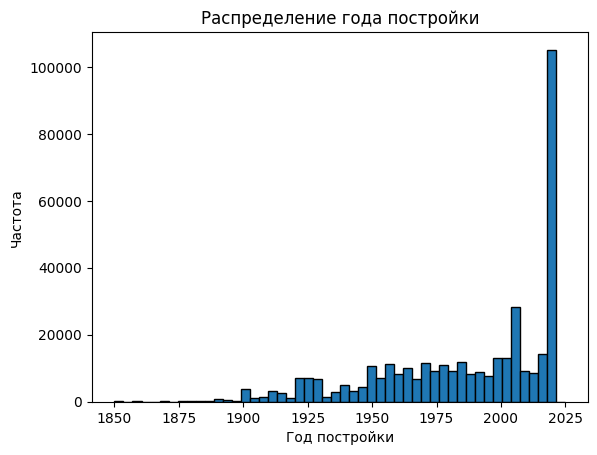

In [67]:
plt.hist(data_2['Year built'], bins=50, edgecolor='black')
plt.xlabel('Год постройки')
plt.ylabel('Частота')
plt.title('Распределение года постройки')
plt.show()

In [33]:
# Из значений признака Year built получим признак Year built_ путем вычетания минимального значения

data_2['Year built_'] = data_2['Year built'] - 1850

In [31]:
data_2['Year built_'].describe()

count    377185.000000
mean        135.968411
std          34.007355
min           0.000000
25%         113.000000
50%         147.000000
75%         169.000000
max         175.000000
Name: Year built_, dtype: float64

Вышеперечисленную операцию с созданием признака Year built_ мы выполняем для усиления влияния фактора постройки объекта недвижимости.

### Обработка подпризнака **Remodeled year** признака **homeFacts**

Этот подпризнак судя из названия дает нам информацию о последнем ремонте/ремоделировании объекта недвижимости.

In [34]:
# функция для извлечения значений подпризнака Remodeled year

def unpack_dict_remodel_year(dict_a):
    dict_a = eval(dict_a)
    V_dict_a = dict_a['atAGlanceFacts']
    for i in V_dict_a:
        if i['factLabel'] == 'Remodeled year':
            try:
                return int(i['factValue'])
            except (ValueError, TypeError):
                return None
    return None

In [35]:
# Создаем подпризнак Remodeled year

data_2['Remodeled year'] = data_2['homeFacts'].map(unpack_dict_remodel_year)

data_2['Remodeled year']

0            NaN
1            NaN
2         1967.0
3         2006.0
4            NaN
           ...  
377180    1990.0
377181       NaN
377182    1950.0
377183       NaN
377184       NaN
Name: Remodeled year, Length: 377185, dtype: float64

In [36]:
# Смотрим на наличие пропусков

data_2['Remodeled year'].isna().sum()

226110

In [37]:
# Заполняем пропуски в столбце Remodeled year значениями признака Year built + 30 

data_2['Remodeled year'] = data_2['Remodeled year'].fillna(data_2['Year built'] + 30)

In [ ]:
# Проверяем на наличие пропусков

data_2['Remodeled year'].isnull().sum()

0

In [75]:
data_2['Remodeled year'].min()

0.0

In [76]:
data_2['Remodeled year'].max()

2055.0

In [38]:
# Все значения Remodeled year меньше 1880 заменяем на 1850

data_2['Remodeled year'][data_2['Remodeled year'] <= 1880] = 1850

In [39]:
# Все значения Remodeled year болььше 2025 заменяем на 2025

data_2['Remodeled year'][data_2['Remodeled year'] >= 2025] = 2025

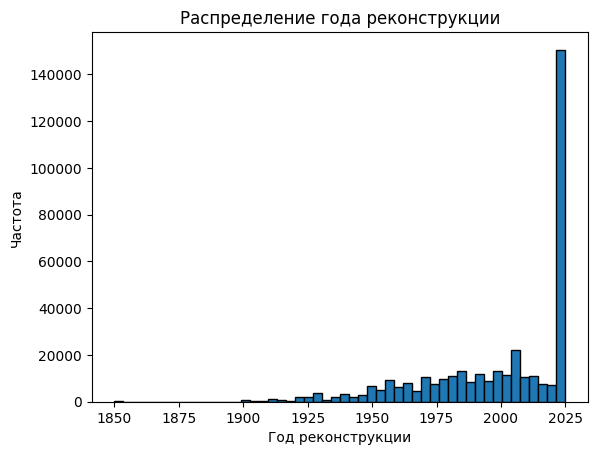

In [79]:
plt.hist(data_2['Remodeled year'], bins=50, edgecolor='black')
plt.xlabel('Год реконструкции')
plt.ylabel('Частота')
plt.title('Распределение года реконструкции')
plt.show()

In [40]:
# Признак значения Remodeled year_ к целому типу

data_2['Remodeled year'] = data_2['Remodeled year'].astype(int)

In [41]:
# Создаем новый признак Remodeled year_ отняв из 2025 значения признака Remodeled year

data_2['Remodeled year_'] = 2025 - data_2['Remodeled year']

In [42]:
data_2['Remodeled year_']

0          0
1          0
2         58
3         19
4          0
          ..
377180    35
377181    71
377182    75
377183     0
377184     0
Name: Remodeled year_, Length: 377185, dtype: int32

In [83]:
data_2['Remodeled year_'].isna().sum()

0

Мы проделали похожую обработку как с годом постройки. Мы выделили именно число лет прошедших с последней модернизации/ремонта

### Обработка подпризнака **Heating** признака **homeFacts**

Этот подпризнак дает информацию о системе отопления.

In [43]:
# функция для извлечения значений подпризнака Heating

def unpack_dict_heatung(dict_a):
    dict_a = eval(dict_a)
    V_dict_a = dict_a['atAGlanceFacts']
    for i in V_dict_a:
        if i['factLabel'] == 'Heating':
            try:
                return i['factValue']
            except (ValueError, TypeError):
                return None
    return None

In [44]:
# Создаем подпризнак Heating

data_2['Heating'] = data_2['homeFacts'].map(unpack_dict_heatung)

data_2['Heating']

0         Central A/C, Heat Pump
1                               
2                     Forced Air
3                     Forced Air
4                               
                   ...          
377180                     Other
377181                   Radiant
377182                     Other
377183                      None
377184                  Electric
Name: Heating, Length: 377185, dtype: object

In [ ]:
# Просматриваем уникальные значения

data_2['Heating'].unique().tolist()

['Central A/C, Heat Pump',
 '',
 'Forced Air',
 'Electric, Heat Pump',
 'Gas',
 'Central Electric',
 'Forced air',
 'Other',
 'Forced air, Heat pump',
 'Central Air',
 'Electric',
 'Heat Pump',
 'Radiant',
 'Baseboard',
 'Central Furnace',
 'No Data',
 'Natural Gas',
 'Central, Electric',
 'Natural Gas Heat',
 'Baseboard/Wall, Electric, Two or More Units',
 'Wall',
 'Lower level-Gas',
 'Central',
 'Electric Heat',
 'Yes',
 'Heat pump',
 'Heating System',
 None,
 'Gas Heat',
 'Forced Air Heating',
 'Refrigeration, Ceiling Fan(s)',
 'Central, Zoned',
 'Forced Air, Natural Gas',
 'Central, Gas',
 'Forced Air, Space Heaters',
 ', Gas Hot Air/Furnace',
 ', Heat Pump - Heat',
 'Central Electric, Zoned',
 'Central Electric, Central Gas',
 'Oil',
 'Forced Air, Gas',
 'Central, Heat Pump',
 'Gas Heat, ENERGY STAR Qualified Equipment',
 'Baseboard, Electric',
 'Gas Gas',
 'Central Air, Ceiling Fan(s)',
 'Central, Electric, Two or More Units',
 'Central Electric, Heat Pump',
 'Radiator, Central H

In [45]:
Mask = data_2['Heating'].unique()

In [46]:
# Колличество уникальных значений

data_2['Heating'].nunique()

1984

In [47]:
# Число пропусков

data_2['Heating'].isna().sum()

3533

In [48]:
# Смотрим какое значение сколько раз встречается в столбце Heating

for i in Mask:
    print(f"{i} - {data_2['Heating'][data_2['Heating'] == i].count()}")    

Central A/C, Heat Pump - 3
 - 105799
Forced Air - 82807
Electric, Heat Pump - 170
Gas - 9296
Central Electric - 7112
Forced air - 51506
Other - 29623
Forced air, Heat pump - 1727
Central Air - 7814
Electric - 10211
Heat Pump - 6104
Radiant - 1485
Baseboard - 3815
Central Furnace - 1036
No Data - 8611
Natural Gas - 193
Central, Electric - 4253
Natural Gas Heat - 1383
Baseboard/Wall, Electric, Two or More Units - 2
Wall - 3301
Lower level-Gas - 1
Central - 6247
Electric Heat - 3064
Yes - 34
Heat pump - 2747
Heating System - 2709
None - 0
Gas Heat - 769
Forced Air Heating - 810
Refrigeration, Ceiling Fan(s) - 239
Central, Zoned - 72
Forced Air, Natural Gas - 737
Central, Gas - 317
Forced Air, Space Heaters - 4
, Gas Hot Air/Furnace - 776
, Heat Pump - Heat - 499
Central Electric, Zoned - 873
Central Electric, Central Gas - 131
Oil - 217
Forced Air, Gas - 962
Central, Heat Pump - 207
Gas Heat, ENERGY STAR Qualified Equipment - 13
Baseboard, Electric - 17
Gas Gas - 53
Central Air, Ceiling F

Смотрим информацию из интернета о системах Heating в США.

https://thefurnaceoutlet.com/blogs/hvac-tips/8-types-of-heating-systems-for-your-home?gad_source=1&gclid=Cj0KCQjwhr6_BhD4ARIsAH1YdjDralOZMSvXdE2utow1EM5y4WUIyMVmlNs2cjcfCSnIqP2_eQB8ol4aAo5HEALw_wcB

Основные виды обогрева в США - газ, дерево, электричество, паровое/бойлерное, forced air - мы будем искать эти слова в названии признака и перегрупировывать его по значениям.

In [49]:
# По этим словам мы будем проводить группировку

Heating_groups = {
    'Gas': ['gas'],
    'Wood': ['wood'],
    'Electric': ['electric', 'a/c'],
    'Boiler': ['boiler', 'steam'],
    'Forced Air': ['condit', 'fan', 'air'],
    'None':['none'],
    'Unclear status': []
}

def get_heating_group(value):
    for group, keywords in sorted(Heating_groups.items(), key=lambda x: len(x[1]), reverse=True):
        if any(keyword.lower() in str(value).lower() for keyword in keywords):
            return group
    return 'Unclear status'

# применяем функцию к каждому значению в массиве
Heating_groups_array = [get_heating_group(value) for value in Mask]

# создаем DataFrame - столбец название признака из Heating - переклассифицированное это название через функцию get_heating_group
Heating_groups_df = pd.DataFrame(list(zip(Mask, Heating_groups_array)), columns=['Heating', 'Heating_rnk'])

# выводим результат
print(Heating_groups_df)

                                                Heating     Heating_rnk
0                                Central A/C, Heat Pump        Electric
1                                                        Unclear status
2                                            Forced Air      Forced Air
3                                   Electric, Heat Pump        Electric
4                                                   Gas             Gas
...                                                 ...             ...
1980                                            Nat Gas             Gas
1981                        Central Furnace,Natural Gas             Gas
1982               Electric Furnace, Electric Heat Pump        Electric
1983             Floor Furnace, Wall Electric, Wall Gas        Electric
1984  Baseboard, Hot Water, Programmable Thermostat,...  Unclear status

[1985 rows x 2 columns]


In [50]:
# Смотрим сколько значений не попали под нашу перегруппировку

Heating_groups_df[Heating_groups_df['Heating_rnk'] == 'Unclear status'].count()

Heating        558
Heating_rnk    558
dtype: int64

In [51]:
# Пропуски в Heating_rnk заменяем наиболее распространенными значениями

mode_rnk = Heating_groups_df['Heating_rnk'].mode()[0]
Heating_groups_df['Heating_rnk'] = Heating_groups_df['Heating_rnk'].fillna(mode_rnk)

Heating_groups_df['Heating_rnk'][Heating_groups_df['Heating_rnk'] == 'Unclear status'] = mode_rnk

In [52]:
# Создаем столбец Heating_pre_ranked путем замены значений Heating на их значения в столбце Heating_rnk в датафрейме Heating_groups_df

data_2['Heating_pre_ranked'] = data_2['Heating'].map(Heating_groups_df.set_index('Heating')['Heating_rnk'])

In [53]:
# Смотрим как распределены уникальные значения в Heating_pre_ranked

A = data_2['Heating_pre_ranked'].unique()

for i in A:
    print(f'{i} - {data_2['Heating_pre_ranked'][data_2['Heating_pre_ranked'] == i].count()}')

Electric - 28790
Forced Air - 330706
Gas - 13738
None - 3605
Boiler - 260
Wood - 86


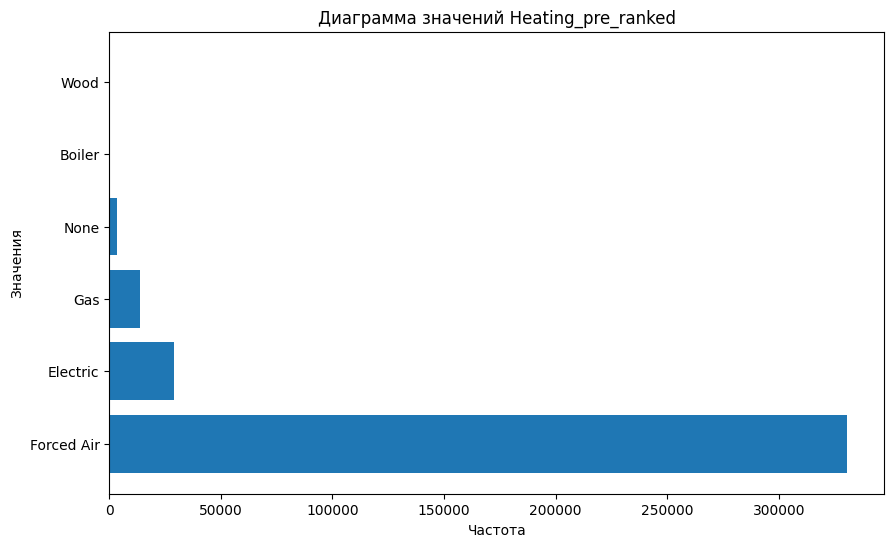

In [96]:
plt.figure(figsize=(10, 6))
plt.barh(data_2['Heating_pre_ranked'].value_counts().index, data_2['Heating_pre_ranked'].value_counts().values)
plt.xlabel('Частота')
plt.ylabel('Значения')
plt.title('Диаграмма значений Heating_pre_ranked')
plt.show()

In [97]:
data_2['Heating_pre_ranked'].isnull().sum()

0

In [54]:
# Создаем из значений Heating_pre_ranked соответствующие бинарные признаки

encoder = ce.OneHotEncoder(cols=['Heating_pre_ranked'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data_2['Heating_pre_ranked'])
data_2 = pd.concat([data_2, type_bin], axis=1)

### Обработка подпризнака **Cooling** признака **homeFacts**

Подпризнак Cooling - система охлаждения. Смотрим информацию из интернета https://www.1-act.com/resources/blog/types-of-cooling-systems/?srsltid=AfmBOop6ktgvZbHMvqycJN3k-Rpj_ZYvWsPmLewGef7vZolqQOqwWVGx

Системы охлаждения быывают следующих типов: Central air condition system, Heat Pump, Mini-Split, Evaporative, Room/Window Air.

In [55]:
# функция для извлечения значений подпризнака Cooling

def unpack_dict_cooling(dict_a):
    dict_a = eval(dict_a)
    V_dict_a = dict_a['atAGlanceFacts']
    for i in V_dict_a:
        if i['factLabel'] == 'Cooling':
            try:
                return i['factValue']
            except (ValueError, TypeError):
                return None
    return None

In [56]:
data_2['Cooling'] = data_2['homeFacts'].map(unpack_dict_cooling)

data_2['Cooling']

0                
1                
2         Central
3         Central
4                
           ...   
377180    Central
377181           
377182           
377183       None
377184    Central
Name: Cooling, Length: 377185, dtype: object

In [57]:
# Смотрим какое значение сколько раз встречается в столбце Cooling

data_2['Cooling'].unique().tolist()

['',
 'Central',
 'Central Air',
 'Central Gas',
 'Steam Heating',
 'Central, Evaporative',
 'Has Cooling',
 'Air Conditioning Unit(s), Ceiling Fan(s)',
 'Central A/C',
 'No Data',
 'Central Electric',
 'None',
 'Central Heating',
 'Wall',
 'Central Air, Gas (Hot Air), Multi-Zone A/C, Multi-Zone Heat, Natural Gas',
 '2 or More Units, Window Unit',
 'Forced Air Heating, Heat Pump, HEPA Air Filtration',
 'Ceiling Fan, Central Electric',
 'g-Energy Star HVAC, g-Fresh Air Ventilation, Gas (Hot Air), Heat Pump for A/C, Multi-Zone A/C, Multi-Zone Heat, Natural Gas',
 'Central A/C (Electric), Central Heat (Gas)',
 'Yes',
 'Central Air, Gas (Hot Air)',
 'Central A/C (Electric), Central Heat (Electric), Heat Pump',
 'Cooling System',
 'Electric',
 'Central, Solar',
 'Refrigeration, Ceiling Fan(s)',
 None,
 'Air Conditioning Unit(s), Central A/C',
 'Gas Heating',
 'Central Air, Zoned',
 'Central A/C (Electric), Central Heat (Gas), Zoned',
 'Other',
 'Central, Wall',
 'Refrigeration, Ceiling Fan(

In [101]:
data_2['Cooling'].nunique()

1445

In [58]:
Mask = data_2['Cooling'].unique()

# создаем словарь для распределения значений Cooling в группы

Cooling_groups = {
    'Central air cond system': ['central', 'air'],
    'Heat Pump': ['heat', 'pump'],
    'Mini-Split': ['mini', 'split'],
    'Evaporative': ['evaporative'],
    'Room/Window Air': ['room', 'window'],
    'Unclear status': []
}

def get_cooling_group(value):
    for group, keywords in sorted(Cooling_groups.items(), key=lambda x: len(x[1]), reverse=True):
        if any(keyword.lower() in str(value).lower() for keyword in keywords):
            return group
    return 'Unclear status'

# применяем функцию к каждому значению в массиве

Cooling_groups_array = [get_cooling_group(value) for value in Mask]

# создаем DataFrame для перевода значений Cooling согласно словарю Cooling_groups

Cooling_groups_df = pd.DataFrame(list(zip(Mask, Cooling_groups_array)), columns=['Cooling', 'Cooling_rnk'])

# выводим результат
print(Cooling_groups_df)

                                                Cooling  \
0                                                         
1                                               Central   
2                                           Central Air   
3                                           Central Gas   
4                                         Steam Heating   
...                                                 ...   
1441  Common Area Maintenance, Common Area Taxes And...   
1442                 No Heat, Space Heater, Window Unit   
1443  Central Air, Electric Hot Air, Gas (Hot Air), ...   
1444  90%+ High Efficiency, Ductless HP-Mini Split, ...   
1445   Central A/C (Gas), Central Heat (Gas), Heat Pump   

                  Cooling_rnk  
0              Unclear status  
1     Central air cond system  
2     Central air cond system  
3     Central air cond system  
4                   Heat Pump  
...                       ...  
1441                Heat Pump  
1442                Heat Pump  
144

In [59]:
Cooling_groups_df

Cooling  \
0                                                         
1                                               Central   
2                                           Central Air   
3                                           Central Gas   
4                                         Steam Heating   
...                                                 ...   
1441  Common Area Maintenance, Common Area Taxes And...   
1442                 No Heat, Space Heater, Window Unit   
1443  Central Air, Electric Hot Air, Gas (Hot Air), ...   
1444  90%+ High Efficiency, Ductless HP-Mini Split, ...   
1445   Central A/C (Gas), Central Heat (Gas), Heat Pump   

                  Cooling_rnk  
0              Unclear status  
1     Central air cond system  
2     Central air cond system  
3     Central air cond system  
4                   Heat Pump  
...                       ...  
1441                Heat Pump  
1442                Heat Pump  
1443  Central air cond system  
1444                Heat Pump  
1445  Central air cond system  

[1446 rows x 2 columns]

In [105]:
Cooling_groups_df['Cooling_rnk'][Cooling_groups_df['Cooling_rnk'] == 'Unclear status'].count()

199

In [106]:
Cooling_groups_df['Cooling'][Cooling_groups_df['Cooling_rnk'] == 'Unclear status'].unique()

array(['', 'Has Cooling', 'No Data', 'None', 'Wall', 'Yes',
       'Cooling System', 'Electric', 'Refrigeration, Ceiling Fan(s)',
       None, 'Other',
       'Refrigeration, Ceiling Fan(s), Programmable Thmstat',
       'Refrigeration',
       'Refrigeration, Ceiling Fan(s), Programmable Thmstat, ENERGY STAR Qualified Equipment',
       'Solar, Refrigeration', 'Wall Unit Cooling', 'Wall Unit(s)',
       'Ceiling Fan(s)', 'Solar', 'Ceiling Fan', '1', 'Other, Wall',
       'Gas', '2 or More Units', '2 or More Units, Electric', 'Zoned A/C',
       'Wall-Unit A/C', 'Multizone A/C', '3+ Units', 'YES',
       'No Cooling/Vent', 'Baseboard, Hot Water', 'Butane',
       'Refrigeration, Programmable Thmstat, ENERGY STAR Qualified Equipment',
       'Zoned', '2', 'Cooling System:', 'Other (See Remarks)',
       'Attic Fan, Ceiling Fan(s)', 'g-Energy Star HVAC, Multizone A/C',
       'Geothermal', 'Refrigeration, Programmable Thmstat',
       'Gas (Floor Furnace)', 'incl', 'Contact manager', '2 

In [60]:
# Создаем столбец Cooling_pre_ranked - аналогично как мы делали с Heating

data_2['Cooling_pre_ranked'] = data_2['Cooling'].map(Cooling_groups_df.set_index('Cooling')['Cooling_rnk'])

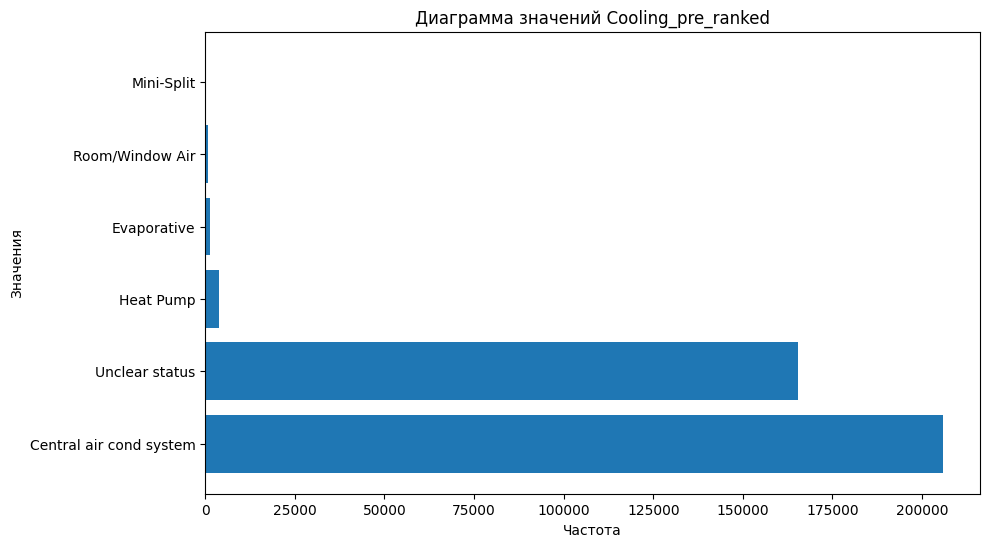

In [108]:
plt.figure(figsize=(10, 6))
plt.barh(data_2['Cooling_pre_ranked'].value_counts().index, data_2['Cooling_pre_ranked'].value_counts().values)
plt.xlabel('Частота')
plt.ylabel('Значения')
plt.title('Диаграмма значений Cooling_pre_ranked')
plt.show()

In [61]:
data_2['Cooling_pre_ranked'].isna().sum()

0

In [62]:
# Проводим бинарное кодирование значений признака Cooling_pre_ranked

encoder = ce.OneHotEncoder(cols=['Cooling_pre_ranked'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data_2['Cooling_pre_ranked'])
data_2 = pd.concat([data_2, type_bin], axis=1)

### Обработка подпризнака **Parking** признака **homeFacts**

Признак дает нам информацию о числе паркомест.

In [63]:
# функция для извлечения значений подпризнака Parking

def unpack_dict_parking(dict_a):
    dict_a = eval(dict_a)
    V_dict_a = dict_a['atAGlanceFacts']
    for i in V_dict_a:
        if i['factLabel'] == 'Parking':
            try:
                return i['factValue']
            except (ValueError, TypeError):
                return None
    return None

In [64]:
data_2['Parking'] = data_2['homeFacts'].map(unpack_dict_parking)

In [113]:
data_2['Parking'].unique().tolist()

['',
 'Attached Garage',
 'Detached Garage',
 'Carport, Attached Garage',
 '2 spaces',
 '4 spaces',
 'Off Street',
 'None',
 '0',
 '1 space',
 'No Data',
 'Carport',
 '2',
 '3 spaces',
 'Double Wide Drive, Oversized Drive',
 'Attached Garage, Detached Garage, Carport',
 '1',
 'Covered Lot',
 '10',
 '7',
 'Detached Garage, Attached Garage',
 'On Street, Detached Garage, Carport',
 'Attached-Detached, ASPHT, GRAVL',
 'Garage Type',
 'Curb Parking, Garage Door Opener',
 'Detached parking',
 '7 spaces',
 'Slab Parking Spaces',
 'Parking YN',
 None,
 "Attch'd Gar Cabinets, Electric Door Opener, Dir Entry frm Garage, Carport Spaces",
 'On street, Attached Garage',
 'Asphalt Driveway, Off Street',
 'Electric Door Opener, Extnded Lngth Garage, Tandem Garage, Dir Entry frm Garage, Slab Parking Spaces',
 '2 Car Garage, Attached, Main Level, Off Street Parking',
 'Off street',
 'Garage - 2 Car',
 'Attached Garage, Driveway',
 'Parking Desc',
 'Off street, On street, Attached Garage',
 '4',
 'Elec

In [114]:
data_2['Parking'].nunique()

3346

In [ ]:
# Смотрим на распределение значений признака Parking

Mask1= data_2['Parking'].unique()

for i in Mask1:
    print(f'{i} - {data_2['Parking'][data_2['Parking'] == i].count()}')

 - 171887
Attached Garage - 70752
Detached Garage - 13201
Carport, Attached Garage - 3025
2 spaces - 28063
4 spaces - 2917
Off Street - 3622
None - 2366
0 - 1114
1 space - 14252
No Data - 13334
Carport - 7743
2 - 2756
3 spaces - 4724
Double Wide Drive, Oversized Drive - 1
Attached Garage, Detached Garage, Carport - 30
1 - 2936
Covered Lot - 7
10 - 41
7 - 37
Detached Garage, Attached Garage - 726
On Street, Detached Garage, Carport - 2
Attached-Detached, ASPHT, GRAVL - 1
Garage Type - 375
Curb Parking, Garage Door Opener - 1
Detached parking - 39
7 spaces - 152
Slab Parking Spaces - 229
Parking YN - 367
None - 0
Attch'd Gar Cabinets, Electric Door Opener, Dir Entry frm Garage, Carport Spaces - 1
On street, Attached Garage - 29
Asphalt Driveway, Off Street - 3
Electric Door Opener, Extnded Lngth Garage, Tandem Garage, Dir Entry frm Garage, Slab Parking Spaces - 1
2 Car Garage, Attached, Main Level, Off Street Parking - 20
Off street - 1657
Garage - 2 Car - 292
Attached Garage, Driveway -

In [65]:
# Функция для извлечения числа парковок из значений подпризнака Parking

def get_parking(s):
    s = str(s)
    matches = matches = re.findall(r'\d', s)
    if len(matches) == 2:
        return int(matches[0]) + int(matches[1])
    elif len(matches) == 3:
        return int(matches[0]) + int(matches[1]) + int(matches[2])
    match = re.search(r'\d{1,3}', s)
    if match:
        return int(match.group())
    if len(re.findall(',', s))>0:
        return len(re.findall(',', s))+1
    if s is not None:
        return 1
    else: return 0       

In [66]:
data_2['Parking_coding'] = data_2['Parking'].map(get_parking)

In [67]:
# Смотрим на получившиеся значения числа парковок

data_2['Parking_coding'].unique()

array([  1,   2,   4,   0,   3,   7,   5,   6,   8,  15,  10,  17,  12,
        24,   9,  14,  27, 520,  16,  11,  13,  18,  19, 202,  40, 101],
      dtype=int64)

In [68]:
for i in data_2['Parking_coding'].unique():
    print(f'{i} - {data_2['Parking_coding'][data_2['Parking_coding'] == i].count()}')

1 - 314859
2 - 45314
4 - 4392
0 - 1114
3 - 7877
7 - 317
5 - 1182
6 - 1243
8 - 355
15 - 7
10 - 43
17 - 6
12 - 10
24 - 252
9 - 161
14 - 6
27 - 2
520 - 1
16 - 9
11 - 15
13 - 9
18 - 5
19 - 1
202 - 1
40 - 3
101 - 1


### Обработка подпризнака **lotsize** признака **homeFacts**

Судя по названию lotsize - имеется ввиду размер лота для продажи - посмотрев на значения мы увидим, что речь идет о площади объекта.

In [69]:
# Функция для извлечения значений подпризнака lotsize

def unpack_dict_lotsize(dict_a):
    dict_a = eval(dict_a)
    V_dict_a = dict_a['atAGlanceFacts']
    for i in V_dict_a:
        if i['factLabel'] == 'lotsize':
            try:
                return i['factValue']
            except (ValueError, TypeError):
                return None
    return None

In [70]:
data_2['lotsize'] = data_2['homeFacts'].map(unpack_dict_lotsize)

In [71]:
data_2['lotsize'].unique().tolist()

[None,
 '5828 sqft',
 '8,626 sqft',
 '8,220 sqft',
 '10,019 sqft',
 '680 sqft',
 '4,996 Sq. Ft.',
 '8,750 Sq. Ft.',
 '124582',
 '2,056 sqft',
 '1.73 acres',
 '5,715 Sq. Ft.',
 '10,270 sqft',
 '7,000 sqft lot',
 '2,130 sqft',
 '2,003 Sq. Ft.',
 '5,304 Sq. Ft.',
 '1,782 Sq. Ft.',
 '10,424 sqft',
 '8,110 sqft',
 '1.18 acres',
 '15.32 acres lot',
 '—',
 '7962 sqft',
 '8,120 sqft',
 '2,080 sqft',
 '3828 sqft',
 '9,000 sqft',
 '5,249 sqft',
 '4828',
 '8,189 sqft lot',
 '0.28 acres',
 '7,782 sqft',
 '',
 '7,440 sqft',
 '5,998 sqft',
 '2.14 acres lot',
 '9.25 acres',
 '0.25 acres',
 '2,052 sqft',
 '7497',
 '0.91 acres lot',
 '7,218 sqft',
 '50530',
 '10018 sqft',
 '7,000 sqft',
 '6,251 sqft',
 '110207',
 '6,000 sqft',
 '9,600 sqft',
 '0.29 acres',
 '1.7 acres',
 'No Data',
 '11920',
 '4,696 sqft',
 '0.62 acres',
 '7,405 sqft',
 '4983',
 '7,680 sqft',
 '10,200 Sq. Ft.',
 '25.41 acres',
 '5,227 sqft lot',
 '103237',
 '9,263 sqft',
 '654 sqft',
 '0.36 acres',
 '5,623 sqft',
 '-- sqft lot',
 '1.02

In [72]:
# Функция для преобразования значений подпризнака lotsize в числа

def process_lotsize(x):
    x = str(x).lower()
    
    #  Если значение столбца приведенное к строковому типу нижнему регистру содержит подстроку 'sq'
    if 'sq' in x:
        x = x.replace('sqft', '').replace('sq', '').replace('ft', '').replace('lot', '').replace(' ', '').replace('-', '').replace(',', '').replace('.', '')
        if x:  # проверяем, что строка не пустая
            return float(x)
        else:
            return None  # или любое другое значение по умолчанию
    
    # Ищем значения столбца состоящие из цифр и слова acres
    elif re.search(r'\d+,?\.\d+ acres', x):
        m = x.replace('acres', '').replace('lot', '').replace(' ', '').replace(',', '').replace('.', ',')
        m = m.replace(',', '.')  # заменить запятую на точку
        return float(m)
    
    
    # Если значение столбца приведенное к строковому типу нижнему регистру содержит подстроку 'acre'
    elif 'acre' in x:
        x = x.replace('acre', '').replace('s', '').replace('lot', '').replace(' ', '').replace(',', '.')
        return float(x) * 43560 # переводим акры в футы
    
      
    match = re.search(r'\d{1,3}', x) # Этот код ищет в строке x совпадение с шаблоном, который представляет собой число, состоящее из 1-3 цифр.
    
    if match:
        return float(match.group())
    else:
        return None
    

# создаем новый столбец data_2['lotsize_sqft']
data_2['lotsize_sqft'] = data_2['lotsize'].apply(lambda x: process_lotsize(x))

In [73]:
# Смотрим, что у нас получилось

data_2['lotsize_sqft'].unique().tolist()

[nan,
 5828.0,
 8626.0,
 8220.0,
 10019.0,
 680.0,
 4996.0,
 8750.0,
 124.0,
 2056.0,
 1.73,
 5715.0,
 10270.0,
 7000.0,
 2130.0,
 2003.0,
 5304.0,
 1782.0,
 10424.0,
 8110.0,
 1.18,
 15.32,
 7962.0,
 8120.0,
 2080.0,
 3828.0,
 9000.0,
 5249.0,
 482.0,
 8189.0,
 0.28,
 7782.0,
 7440.0,
 5998.0,
 2.14,
 9.25,
 0.25,
 2052.0,
 749.0,
 0.91,
 7218.0,
 505.0,
 10018.0,
 6251.0,
 110.0,
 6000.0,
 9600.0,
 0.29,
 1.7,
 119.0,
 4696.0,
 0.62,
 7405.0,
 498.0,
 7680.0,
 10200.0,
 25.41,
 5227.0,
 103.0,
 9263.0,
 654.0,
 0.36,
 5623.0,
 1.02,
 10411.0,
 2.59,
 1.11,
 0.75,
 0.34,
 87120.0,
 199.0,
 7500.0,
 1.41,
 10000.0,
 0.92,
 0.47,
 9605.0,
 5301.0,
 5536.0,
 0.45,
 7318.0,
 8178.0,
 9716.0,
 7800.0,
 1006.0,
 4.3,
 9583.0,
 4394.0,
 2657.0,
 0.27,
 2613.0,
 0.39,
 43560.0,
 8276.0,
 9885.0,
 7823.0,
 3920.0,
 740.0,
 4900.0,
 6987.0,
 3659.0,
 6534.0,
 0.53,
 8398.0,
 8786.0,
 8677.0,
 435.0,
 4970.0,
 1.06,
 5000.0,
 6969.0,
 7841.0,
 3339.0,
 8450.0,
 0.72,
 4791.0,
 6005.0,
 653.0,
 1

In [ ]:
# Смотрим на пропуски

data_2['lotsize_sqft'].isna().sum()

95855

In [74]:
# Смотрим на выбросы - площадь более 15 000 футов

data_2['lotsize_sqft'][data_2['lotsize_sqft'] >= 15000].count()

2193

У нас довольно много пропусков, но мы их не будем "вслепую" заменять модой или медианой значений. Мы будем использовать медианные значения признака lotsize_sqft по штатам и заменять ими пропуски.

In [75]:
States = data['state'].unique()

States

array(['NC', 'WA', 'CA', 'TX', 'FL', 'PA', 'TN', 'IA', 'NY', 'OR', 'DC',
       'NV', 'AZ', 'GA', 'IL', 'NJ', 'MA', 'OH', 'IN', 'UT', 'MI', 'VT',
       'MD', 'CO', 'VA', 'KY', 'MO', 'WI', 'ME', 'MS', 'OK', 'SC', 'MT',
       'DE', 'Fl', 'BA', 'AL', 'OT', 'OS'], dtype=object)

In [76]:
# Создаем словарь где названию штата соответствуют медианные значения lotsize_sqft

State_lotsize_median = {}

for s in States:
    State_lotsize_median[s] = data_2['lotsize_sqft'][data_2['state'] == s].median()
    
State_lotsize_median

{'NC': 22.1,
 'WA': 697.0,
 'CA': 3268.0,
 'TX': 5078.5,
 'FL': 3049.0,
 'PA': 1119.0,
 'TN': 239.0,
 'IA': 435.0,
 'NY': 2178.0,
 'OR': 4777.5,
 'DC': 1450.0,
 'NV': 3920.0,
 'AZ': 647.0,
 'GA': 479.0,
 'IL': 3125.0,
 'NJ': 406.5,
 'MA': 2106.0,
 'OH': 804.0,
 'IN': 3703.0,
 'UT': 3049.0,
 'MI': 4356.0,
 'VT': 313.0,
 'MD': 587.0,
 'CO': 2210.0,
 'VA': 277.0,
 'KY': 328.5,
 'MO': 4104.5,
 'WI': 496.5,
 'ME': 234.5,
 'MS': 255.0,
 'OK': 235.0,
 'SC': 217.0,
 'MT': 513.5,
 'DE': nan,
 'Fl': nan,
 'BA': nan,
 'AL': 174.0,
 'OT': nan,
 'OS': nan}

Мы видим, что для пяти штатов у нас пропуски в значениях - давайте посмотрим эти записи.

In [ ]:
# Смотрим для какого щтата сколько имеем значений

print (f'DE - {data_2['state'][data_2['state'] == 'DE'].count()}')
print (f'Fl - {data_2['state'][data_2['state'] == 'Fl'].count()}')
print (f'BA - {data_2['state'][data_2['state'] == 'BA'].count()}')
print (f'OT - {data_2['state'][data_2['state'] == 'OT'].count()}')
print (f'OS - {data_2['state'][data_2['state'] == 'OS'].count()}')

# Видим, что этих значений немного - с этими пропусками можно индивидуально поработать

DE - 5
Fl - 1
BA - 1
OT - 1
OS - 1


In [130]:
data_2['sqft'][(data_2['state'] == 'DE') | (data_2['state'] == 'Fl') | (data_2['state'] == 'BA') | (data_2['state'] == 'OT') | (data_2['state'] == 'OS')]

86503     Total interior livable area: 1,112 sqft
101135      Total interior livable area: 555 sqft
113694                                      1,140
122666      Total interior livable area: 558 sqft
143930    Total interior livable area: 3,301 sqft
172273                                      7,728
193466                                        NaN
308229                                      1,100
336631                                   882 sqft
Name: sqft, dtype: object

In [131]:
data_2['target'][(data_2['state'] == 'DE') | (data_2['state'] == 'Fl') | (data_2['state'] == 'BA') | (data_2['state'] == 'OT') | (data_2['state'] == 'OS')]

86503       $418,200
101135      $174,900
113694       174,000
122666      $191,900
143930    $1,322,889
172273       225,000
193466        50,000
308229       125,000
336631      $301,300
Name: target, dtype: object

In [77]:
# Назначаем в пропуски значения исходя из анализа значений в соответствующих строках значений sqft и target

data_2['lotsize_sqft'].iloc[86503] = 1112
data_2['lotsize_sqft'].iloc[101135] = 555
data_2['lotsize_sqft'].iloc[113694] = 1140
data_2['lotsize_sqft'].iloc[122666] = 558
data_2['lotsize_sqft'].iloc[143930] = 3301
data_2['lotsize_sqft'].iloc[172273] = 7728
data_2['lotsize_sqft'].iloc[193466] = 440
data_2['lotsize_sqft'].iloc[308229] = 1100
data_2['lotsize_sqft'].iloc[86503] = 882

In [78]:
data_2['lotsize_sqft'] = data_2['lotsize_sqft'].fillna(data_2['state'].map(State_lotsize_median))

In [66]:
data_2['lotsize_sqft'].describe()

count    3.771840e+05
mean     6.899185e+03
std      2.699102e+05
min      0.000000e+00
25%      2.000000e+02
50%      3.049000e+03
75%      5.501000e+03
max      4.247100e+07
Name: lotsize_sqft, dtype: float64

In [79]:
State_lotsize_median_ = {}

for s in States:
    State_lotsize_median_[s] = data_2['lotsize_sqft'][data_2['state'] == s].median()
    
State_lotsize_median_

{'NC': 22.1,
 'WA': 697.0,
 'CA': 3268.0,
 'TX': 5078.5,
 'FL': 3049.0,
 'PA': 1119.0,
 'TN': 239.0,
 'IA': 435.0,
 'NY': 2178.0,
 'OR': 4777.5,
 'DC': 1450.0,
 'NV': 3920.0,
 'AZ': 647.0,
 'GA': 479.0,
 'IL': 3125.0,
 'NJ': 406.5,
 'MA': 2106.0,
 'OH': 804.0,
 'IN': 3703.0,
 'UT': 3049.0,
 'MI': 4356.0,
 'VT': 313.0,
 'MD': 587.0,
 'CO': 2210.0,
 'VA': 277.0,
 'KY': 328.5,
 'MO': 4104.5,
 'WI': 496.5,
 'ME': 234.5,
 'MS': 255.0,
 'OK': 235.0,
 'SC': 217.0,
 'MT': 513.5,
 'DE': 720.0,
 'Fl': 1140.0,
 'BA': 7728.0,
 'AL': 174.0,
 'OT': 440.0,
 'OS': 1100.0}

In [80]:
data_2['lotsize_sqft'] = data_2['lotsize_sqft'].fillna(data_2['state'].map(State_lotsize_median_))

In [81]:
data_2['lotsize_sqft'][data_2['lotsize_sqft'] == 0].count()

384

In [82]:
# Проводим соответствующую нашей 'задумке' замену

data_2['lotsize_sqft'][data_2['lotsize_sqft'] == 0] = data_2['state'].map(State_lotsize_median_)

In [83]:
data_2['lotsize_sqft'][data_2['lotsize_sqft'] == 0].count()

0

In [84]:
data_2['lotsize_sqft'].isna().sum()

0

In [141]:
data_2['lotsize_sqft'].describe()

count    3.771850e+05
mean     6.902177e+03
std      2.699098e+05
min      2.500000e-01
25%      2.030000e+02
50%      3.049000e+03
75%      5.501000e+03
max      4.247100e+07
Name: lotsize_sqft, dtype: float64

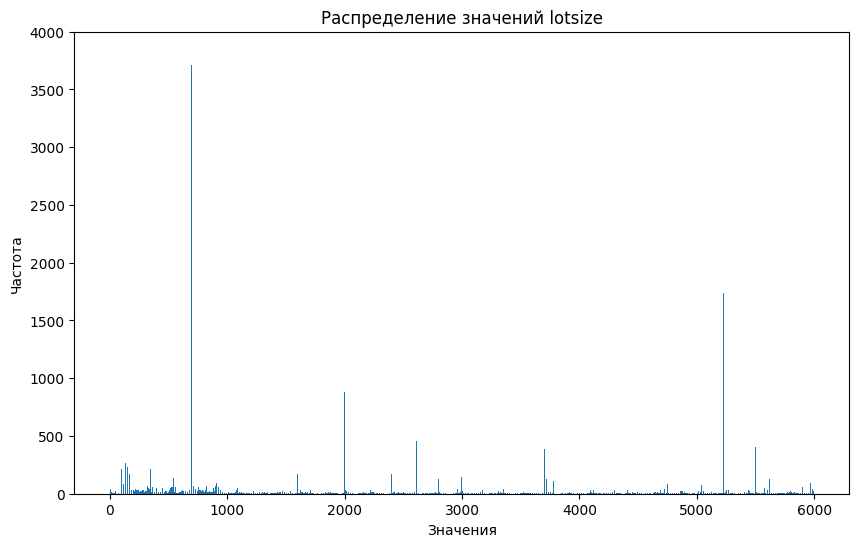

In [142]:
M = data_2['lotsize_sqft'][data_2['lotsize_sqft'] < 6000]

plt.figure(figsize=(10, 6))
plt.bar(M.value_counts().index, M.value_counts().values)
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Распределение значений lotsize')
plt.ylim(0, 4000)  # Установить верхнюю границу оси Y
plt.show()


Значения признака имеют большие выбросы, но мы не будем спешить удалять строки с этими записями - может быть мы найдем при анализе других признаков (sqft например).

In [143]:
fig = go.Figure(data=go.Choropleth(
    locations=States, # list of state abbreviations
    z = list(State_lotsize_median_.values()), # values from the dictionary
    locationmode = 'USA-states', # tells plotly to use state abbreviations
    colorscale = 'Reds', # color scheme
    colorbar_title = 'Median Lot Size (sqft)'
))

fig.update_layout(
    title_text='Median Lot Size by State',
    geo_scope='usa' # limits the map to the United States
)

fig.show()

Построив график распределения значений признака по штатам, мы увидим, что наибольшие значения лотов в штатах Техас, Орегон, Мичиган. Возможно потом мы сгрупируем по значениям lotsize значения признака state для последующей перекодировки.

### Обработка подпризнака **Price/sqft** признака **homeFacts**

Этот подпризнак нам говорит о цене квадратного фута. По логике этот подпризнак будет сильно коррелировать с target и информация содержащаяся в нем лишняя и будет вести к перетечки данных из целевого признака в модель. И в дальнейшем нам этот подпризнак прийдется удалить из датасета. Несмотря на это подпризнак целесообразно будет изучить.

In [85]:
# функция для извлечения значений подпризнака Price/sqft

def unpack_dict_pricesqft(dict_a):
    dict_a = eval(dict_a)
    V_dict_a = dict_a['atAGlanceFacts']
    for i in V_dict_a:
        if i['factLabel'] == 'Price/sqft':
            try:
                return i['factValue']
            except (ValueError, TypeError):
                return None
    return None

In [86]:
data_2['Price/sqft'] = data_2['homeFacts'].map(unpack_dict_pricesqft)

In [146]:
data_2['Price/sqft'].unique().tolist()

['$144',
 '$159/sqft',
 '$965/sqft',
 '$371/sqft',
 None,
 '$233/sqft',
 '$120 / Sq. Ft.',
 '$57 / Sq. Ft.',
 '$68',
 '$162',
 '$515/sqft',
 '$83 / Sq. Ft.',
 '$185/sqft',
 '$275',
 '$69',
 '$152 / Sq. Ft.',
 '$797 / Sq. Ft.',
 '$119/sqft',
 '$388/sqft',
 '$217',
 '$665',
 '$536 / Sq. Ft.',
 '$137/sqft',
 '$93/sqft',
 '$647/sqft',
 '$194/sqft',
 '$238/sqft',
 '$888/sqft',
 '$688',
 '$156',
 '$174/sqft',
 '$165',
 '$122/sqft',
 '$289/sqft',
 '$197',
 '$355',
 '$96',
 '$224/sqft',
 '$260/sqft',
 '$116/sqft',
 '$453',
 '$267',
 '$139/sqft',
 '$498/sqft',
 '$950',
 '$257/sqft',
 '$107/sqft',
 '$642',
 'No Info',
 '$154/sqft',
 '$213/sqft',
 '$163/sqft',
 '$344/sqft',
 '$152',
 '$115',
 '$136/sqft',
 '$340/sqft',
 '$205/sqft',
 '$118',
 '$617/sqft',
 '$190 / Sq. Ft.',
 '$454/sqft',
 '$300',
 '$81',
 '$397/sqft',
 '$271/sqft',
 '$865/sqft',
 '$1208 / Sq. Ft.',
 '$168',
 '$145',
 '$147',
 '$132/sqft',
 '$155/sqft',
 '$102/sqft',
 '$196/sqft',
 '$115/sqft',
 '$373/sqft',
 '$139',
 '$119',
 '$2

In [87]:
# Преобразуем значения Price/sqft в цифровую форму

def process_pice(x):
    if x is None:
        return None
    x = str(x).lower()
    x = x.replace('$', '').replace('sqft', '').replace('ft', '').replace('sq', '').replace('no info', '').replace('/', '').replace('.', '').replace(' ', '')
    try:
        return int(x)
    except ValueError:
        return None
    
       

# создаем новый столбец data['price_sqft_'] с цифровизированными значениями Price/sqft

data_2['Price/sqft_'] = data_2['Price/sqft'].apply(lambda x: process_pice(x))

In [88]:
# Смотрим на получившиеся пропуски

data_2['Price/sqft_'].isna().sum()

73066

Заполнять пропуски будем "приемом", проделанным с lotsize  - будем заменять медианными значениями признака по штатам.

In [89]:
State_pricesqft_median = {}

for s in States:
    State_pricesqft_median[s] = data_2['Price/sqft_'][data_2['state'] == s].median()
    
State_pricesqft_median

{'NC': 147.0,
 'WA': 274.0,
 'CA': 417.0,
 'TX': 141.0,
 'FL': 187.0,
 'PA': 166.0,
 'TN': 148.0,
 'IA': 91.0,
 'NY': 410.0,
 'OR': 249.0,
 'DC': 474.0,
 'NV': 182.0,
 'AZ': 153.0,
 'GA': 185.0,
 'IL': 180.0,
 'NJ': 168.5,
 'MA': 495.5,
 'OH': 94.0,
 'IN': 95.0,
 'UT': 202.0,
 'MI': 55.0,
 'VT': 154.0,
 'MD': 238.0,
 'CO': 238.0,
 'VA': 279.0,
 'KY': 68.0,
 'MO': 111.0,
 'WI': 98.0,
 'ME': 95.0,
 'MS': 86.5,
 'OK': 83.0,
 'SC': 140.0,
 'MT': 79.0,
 'DE': 344.0,
 'Fl': 153.0,
 'BA': 29.0,
 'AL': nan,
 'OT': nan,
 'OS': 114.0}

In [90]:
data_2['sqft'][(data_2['state'] == 'AL') | (data_2['state'] == 'OT')]

192141      0
193466    NaN
Name: sqft, dtype: object

In [151]:
data_2['target'][(data_2['state'] == 'AL') | (data_2['state'] == 'OT')]

192141    $72,000
193466     50,000
Name: target, dtype: object

In [91]:
data_2['Price/sqft_'].iloc[192141] = 136
data_2['Price/sqft_'].iloc[193466] = 94

In [92]:
State_pricesqft_median_ = {}

for s in States:
    State_pricesqft_median_[s] = data_2['Price/sqft_'][data_2['state'] == s].median()
    
State_pricesqft_median_

{'NC': 147.0,
 'WA': 274.0,
 'CA': 417.0,
 'TX': 141.0,
 'FL': 187.0,
 'PA': 166.0,
 'TN': 148.0,
 'IA': 91.0,
 'NY': 410.0,
 'OR': 249.0,
 'DC': 474.0,
 'NV': 182.0,
 'AZ': 153.0,
 'GA': 185.0,
 'IL': 180.0,
 'NJ': 168.5,
 'MA': 495.5,
 'OH': 94.0,
 'IN': 95.0,
 'UT': 202.0,
 'MI': 55.0,
 'VT': 154.0,
 'MD': 238.0,
 'CO': 238.0,
 'VA': 279.0,
 'KY': 68.0,
 'MO': 111.0,
 'WI': 98.0,
 'ME': 95.0,
 'MS': 86.5,
 'OK': 83.0,
 'SC': 140.0,
 'MT': 79.0,
 'DE': 344.0,
 'Fl': 153.0,
 'BA': 29.0,
 'AL': 136.0,
 'OT': 94.0,
 'OS': 114.0}

In [93]:
data_2['Price/sqft_'] = data_2['Price/sqft_'].fillna(data_2['state'].map(State_pricesqft_median_))

In [155]:
data_2['Price/sqft_'].describe()

count    3.771850e+05
mean     2.578873e+02
std      8.902676e+03
min      0.000000e+00
25%      1.300000e+02
50%      1.840000e+02
75%      2.810000e+02
max      5.000000e+06
Name: Price/sqft_, dtype: float64

In [80]:
data_2['Price/sqft_'].isna().sum()

0

In [157]:
M = data_2['Price/sqft_'][data_2['Price/sqft_'] < 285]

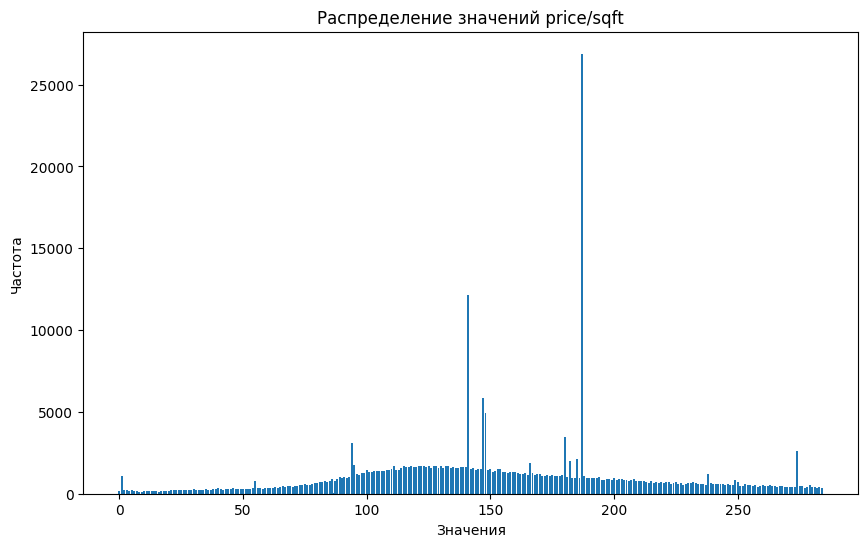

In [158]:
plt.figure(figsize=(10, 6))
plt.bar(M.value_counts().index, M.value_counts().values)
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Распределение значений price/sqft')
plt.show()

Мы видим, что имеем довольно большие выбросы. Если на них не обращать внимание, то распределение значений признака близко к нормальному.

In [159]:
fig = go.Figure(data=go.Choropleth(
    locations=States, # list of state abbreviations
    z = list(State_pricesqft_median.values()), # values from the dictionary
    locationmode = 'USA-states', # tells plotly to use state abbreviations
    colorscale = 'Reds', # color scheme
    colorbar_title = 'Median price sqft'
))

fig.update_layout(
    title_text='Median price sqft',
    geo_scope='usa' # limits the map to the United States
)

fig.show()

Мы построили график распределения цены квадратного фута по штатам. Наибольшие цены наблюдаются в штатах Калифорния, Нью-Йорк, Массачусетс. Возможно эту информацию мы используем для перекодирования признака states.

Мы закончили с обработкой информации признака homeFacts. Мы оставим оцифрованные столбцы и удалим "технические" столбцы, которые "помогли" нам извлечь оцифрованную информацию. Так же в дальнейшем целесообразно удалить признак 'Price/sqft_', так как он будет сильно кореллировать с целевым признаком.

In [94]:
data_2 = data_2.drop(['homeFacts', 'Year built', 'Remodeled year', 'Heating', 'Heating_pre_ranked', 'Cooling', 'Cooling_pre_ranked', 'Parking', 'lotsize', 'Price/sqft'], axis=1)

In [161]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 40 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   baths                                       377185 non-null  int32  
 1   fireplace                                   103114 non-null  object 
 2   schools                                     377185 non-null  object 
 3   sqft                                        336608 non-null  object 
 4   beds                                        285903 non-null  object 
 5   state                                       377185 non-null  object 
 6   stories                                     226469 non-null  object 
 7   mls-id                                      24942 non-null   object 
 8   PrivatePool                                 40311 non-null   object 
 9   MlsId                                       310305 non-null  object 
 

## Изучение признака fireplace

Этот признак нам говорит о системе обогрева в доме - наличие камина, возможно он дублирует информацию, которую мы получили из Heating. Возможно, что система обогрева в домке отличатся непосредственно от самого обогревающего инструмента.

In [ ]:
# смотрим уникальные значения и сколько раз они присутствуют в столбце fireplace

data_2['fireplace'].unique().tolist()

['Gas Logs',
 nan,
 'yes',
 'Yes',
 '2',
 '0',
 '1',
 'Not Applicable',
 'Fireplace YN',
 '5',
 'Family Room, Master Bedroom',
 '1 Fireplace',
 'Fireplace',
 'Living Room, Wood Burning',
 '1 Fireplace, Exterior Fireplace',
 '3',
 'N/K',
 'Firepit, Gas Fireplace',
 'Gas Logs, In Den/Family Room',
 'FAMILYRM',
 'Wood',
 'Direct Vent, Gas Log, 1 Fireplace',
 'Family Room, Living Room, Wood Burning',
 '1 Fireplace, Wood Burning',
 'Extra Closets',
 'Gas Logs, Great Room',
 'Special Features',
 'No',
 'Gas, Propane',
 'Great Room',
 'Ceiling Fan, Extra Closets, Storage, Utility Connection',
 'Gas, Living Room',
 'Insert, Wood',
 'Living Room',
 'Fireplace Features',
 'Gas Logs, In Great Room',
 'Ceiling Fan, Central Vacuum, Elevator, Extra Closets, Storage, Walk-In Closets',
 'Living Room, Natural Gas',
 'Baseboard, Fireplace-Wood, Hot Water/Steam, Radiators',
 'Gas Log Starter, Gas Logs, In Great Room',
 'Electric',
 'Gas Log, 1 Fireplace',
 'Ceiling Fan, Walk-In Closets, Wood Burning FP',

In [95]:
Mask_fireplace = data_2['fireplace'].unique()

for i in Mask_fireplace:
    print(f"{i} - {data_2['fireplace'][data_2['fireplace'] == i].count()}")    

Gas Logs - 107
nan - 0
yes - 50356
Yes - 20856
2 - 2432
0 - 271
1 - 14544
Not Applicable - 1993
Fireplace YN - 287
5 - 65
Family Room, Master Bedroom - 2
1 Fireplace - 274
Fireplace - 847
Living Room, Wood Burning - 185
1 Fireplace, Exterior Fireplace - 6
3 - 564
N/K - 47
Firepit, Gas Fireplace - 2
Gas Logs, In Den/Family Room - 89
FAMILYRM - 246
Wood - 206
Direct Vent, Gas Log, 1 Fireplace - 5
Family Room, Living Room, Wood Burning - 18
1 Fireplace, Wood Burning - 3
Extra Closets - 17
Gas Logs, Great Room - 188
Special Features - 279
No - 289
Gas, Propane - 1
Great Room - 207
Ceiling Fan, Extra Closets, Storage, Utility Connection - 21
Gas, Living Room - 56
Insert, Wood - 2
Living Room - 433
Fireplace Features - 239
Gas Logs, In Great Room - 112
Ceiling Fan, Central Vacuum, Elevator, Extra Closets, Storage, Walk-In Closets - 1
Living Room, Natural Gas - 14
Baseboard, Fireplace-Wood, Hot Water/Steam, Radiators - 1
Gas Log Starter, Gas Logs, In Great Room - 14
Electric - 72
Gas Log, 1 F

In [96]:
# сортируем уникальные значения по частоте нахождения в столбце fireplace

sorted_fireplace_values = data_2['fireplace'].value_counts().reset_index()
sorted_fireplace_values.columns = ['fireplace', 'count']

In [165]:
pd.set_option('display.max_rows', 1652)
print(sorted_fireplace_values[['fireplace', 'count']])

                                              fireplace  count
0                                                   yes  50356
1                                                   Yes  20856
2                                                     1  14544
3                                                     2   2432
4                                        Not Applicable   1993
5                                             Fireplace    847
6                                                     3    564
7                                           Living Room    433
8                                              LOCATION    399
9                                          Wood Burning    311
10                                         Gas/Gas Logs    300
11                                                   No    289
12                                         Fireplace YN    287
13                                     Special Features    279
14                                          1 Fireplace

Информация из интернета о каминах в домах в США

https://www.forumdaily.com/zima-blizko-kakie-sistemy-obogreva-pomeshhenij-ispolzuyut-v-ssha/

https://www.thespruce.com/types-of-fireplaces-8744385

Мы выделим следующие группы, связанные с каминами: Gas, Wood, Electric, Boiler, Condition.

In [97]:
# список всех возможных значений
fireplace_values = data_2['fireplace'].unique()  

# создаем словарь для значений в группы
fireplace_groups = {
    'Gas': ['gas'],
    'Wood': ['wood'],
    'Electric': ['electric', 'heat'],
    'Boiler': ['boiler', 'steam'],
    'Condition': ['condit', 'fan', 'air'],
    'Nan':['nan'],
    'Unclear status': []
}

# Фильтруем в группы по ключевым словам
def get_fireplace_group(value):
    for group, keywords in sorted(fireplace_groups.items(), key=lambda x: len(x[1]), reverse=True):
        if any(keyword.lower() in str(value).lower() for keyword in keywords):
            return group
    return 'Unclear status'

# применяем функцию к каждому значению в массиве
fireplace_groups_array = [get_fireplace_group(value) for value in fireplace_values]

# создаем DataFrame, переврдящий значение fireplace в группу
fireplace_groups_df = pd.DataFrame(list(zip(fireplace_values, fireplace_groups_array)), columns=['fireplace', 'fireplace_rnk'])

# выводим результат
print(fireplace_groups_df)

                                              fireplace   fireplace_rnk
0                                              Gas Logs             Gas
1                                                   NaN             Nan
2                                                   yes  Unclear status
3                                                   Yes  Unclear status
4                                                     2  Unclear status
...                                                 ...             ...
1648      Basement - Finished, Fireplace - Wood Burning            Wood
1649  Elevator, Intercom, Utility Connection, Walk-I...            Wood
1650  Ceiling Fan, Fire Sprinkler System, Storage, U...       Condition
1651  Fireplace-Gas, Fireplace-Wood, Patio, Walk-in ...             Gas
1652  Ceiling Fan, SMAPL, Utility Connection, Walk-I...       Condition

[1653 rows x 2 columns]


In [98]:
sorted_fireplace_rnk_values = fireplace_groups_df['fireplace_rnk'].value_counts().reset_index()

sorted_fireplace_rnk_values.columns = ['fireplace_rnk', 'count']

sorted_fireplace_rnk_values

fireplace_rnk  count
0             Gas    531
1  Unclear status    467
2       Condition    345
3            Wood    221
4        Electric     81
5          Boiler      7
6             Nan      1

Большая часть значений связана с газом, но также много значений нам не удалось распределить в группы.

In [99]:
data_2['fireplace_pre_ranked'] = data_2['fireplace'].map(fireplace_groups_df.set_index('fireplace')['fireplace_rnk'])

In [100]:
# переводим значения столбца fireplace согласно fireplace_groups_df

A = data_2['fireplace_pre_ranked'].unique()

for i in A:
    print(f"{i} - {data_2['fireplace_pre_ranked'][data_2['fireplace_pre_ranked'] == i].count()}")

Gas - 3121
Nan - 274071
Unclear status - 96644
Wood - 1630
Condition - 1482
Boiler - 9
Electric - 228


In [101]:
# смотрим получившиеся пропуски

data_2['fireplace'].isna().sum()

274071

На основании информации из интернета камины в большей часть домов в США отапливаются газом, поэтому пропуски и неопределенные значения мы кодируем, как отопление газом.

In [103]:
data_2['fireplace_pre_ranked'] = data_2['fireplace_pre_ranked'].replace(['Nan', 'Unclear status'], 'Gas')

In [104]:
A = data_2['fireplace_pre_ranked'].unique()

for i in A:
    print(f"{i} - {data_2['fireplace_pre_ranked'][data_2['fireplace_pre_ranked'] == i].count()}")

Gas - 373836
Wood - 1630
Condition - 1482
Boiler - 9
Electric - 228


In [105]:
# Перекодируем бинарным способом, получившийся обработанный столбец fireplace по группам через OneHotEncoder

encoder = ce.OneHotEncoder(cols=['fireplace_pre_ranked'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data_2['fireplace_pre_ranked'])
data_2 = pd.concat([data_2, type_bin], axis=1)

In [106]:
# Информацию столбца fireplace и fireplace_pre_ranke удаляем, т.к. мы ее уже закодировали

data_2 = data_2.drop(columns=['fireplace', 'fireplace_pre_ranked'])

In [107]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 44 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   baths                                       377185 non-null  int32  
 1   schools                                     377185 non-null  object 
 2   sqft                                        336608 non-null  object 
 3   beds                                        285903 non-null  object 
 4   state                                       377185 non-null  object 
 5   stories                                     226469 non-null  object 
 6   mls-id                                      24942 non-null   object 
 7   PrivatePool                                 40311 non-null   object 
 8   MlsId                                       310305 non-null  object 
 9   target                                      374704 non-null  object 
 

In [ ]:
# промежуточное сохранение получившегося обработанного датасета на случай зависания системы

data_2.to_csv('data_beta_untill_schools.csv', index=False)

In [ ]:
data_2 = pd.read_csv('data_beta_untill_schools.csv')

## Изучение признака **schools**

Признак schools дает нам информацию об учебных заведениях, что должно оказывать влияние на цену недвижимости.
Этот признак, также как homeFacts, представляет из себя список вложенных словарей. Из него мы также будем извлекать несколько подпризнаков для дальнейшей цифровизации, имеющейся информации.

Значения списка признака schools:
- Словарь с ключом rating(рейтинг школ) - указывает на список длиной в колличествоо ближайших школ с записями об их рейтинге.
- Словарь с ключом data - указывает на список из трех словарей:
 
                        - Словарь с ключом Distance -  указывает на список длиной в колличествоо ближайших школ с записями о растоянии до них.
  
                        - Словарь с ключом Grades -  указывает на список длиной в колличествоо ближайших школ с записями о типе школ (начальная школа, колледж и прочее).
 
                        - Словарь с ключом name - указывает на список длиной в колличествоо ближайших школ с записями об их названиях.

In [ ]:
# смотрим запись столбца schools с 0-м индексом

data_2['schools'][0]

'[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]'

'[
    {\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'],
     \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'],
                 \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, 
                 \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']
                 }
]'

In [ ]:
# смотрим запись столбца schools с 100-м индексом

data_2['schools'][100]

"[{'rating': ['6/10', '4/10', '4/10'], 'data': {'Distance': ['3.9 mi', '3.6 mi', '2.7 mi'], 'Grades': ['K-5', '6-8', '9-12']}, 'name': ['Oceanway Elementary School', 'Oceanway School', 'First Coast High School']}]"

"[
    {'rating': ['6/10', '4/10', '4/10'],
     'data': {'Distance': ['3.9 mi', '3.6 mi', '2.7 mi'],
              'Grades': ['K-5', '6-8', '9-12']},
              'name': ['Oceanway Elementary School', 'Oceanway School', 'First Coast High School']
              }
]"

In [ ]:
# Пропусков в записях schools не обнаружено

data_2['schools'].isna().sum()

0

### Обработка подпризнака **rating** признака **schools**

In [108]:
# Функция для извлечения значения ключа rating - словаря внутри списка schools

def unpack_dict_rating(dict_b):
    dict_b = eval(dict_b)
    V_dict_b = dict_b[0]['rating']
    return V_dict_b

In [109]:
# создаем новый признак schools_rating путем выделения значения ключа rating

data_2['schools_rating'] = data_2['schools'].map(unpack_dict_rating)

In [110]:
# уникальных значений рейтингов немного и их можно оцифровать

unique_rating = data_2['schools_rating'].explode().unique()

unique_rating

array(['4', '7', 'NR', '4/10', 'None/10', '8/10', '9/10', '10/10', '5/10',
       nan, '3', '1', '2', '3/10', '2/10', '6', '5', '7/10', '8', '6/10',
       '10', '9', '1/10', 'NA', ''], dtype=object)

In [182]:
len(unique_rating)

25

In [111]:
# Функция для преобразования рейтингов в числа

def rating_to_int(rt):
    if type(rt) == float:
        return int(0)
    elif rt in ['None/10', 'NR', 'nan', 'NA', '']:
        return int(0)
    if '/' in rt:
        value = rt.split('/')[0]
        return int(value)
    return int(rt)

In [112]:
rating_to_int = np.vectorize(rating_to_int)

rating_to_int(unique_rating)

array([ 4,  7,  0,  4,  0,  8,  9, 10,  5,  0,  3,  1,  2,  3,  2,  6,  5,
        7,  8,  6, 10,  9,  1,  0,  0])

In [113]:
# Переводим каждое значение получившегося в списке 'schools_rating' в цифровую форму

data_2['schools_rating_int_coding'] = data_2['schools_rating'].apply(lambda x: [rating_to_int(rt) for rt in x])

In [114]:
# В каждой строке schools_rating_int_coding у нас список цифр, соответствующий рейтингу школы вблизи нашего объекта недвижимости

data_2['schools_rating_int_coding']

0         [4, 4, 7, 0, 4, 7, 0, 0]
1                        [4, 0, 4]
2                        [8, 4, 8]
3                    [9, 9, 10, 9]
4                        [4, 5, 5]
                    ...           
377180                     [10, 5]
377181                   [1, 5, 7]
377182                      [5, 4]
377183                   [0, 0, 0]
377184                   [5, 4, 3]
Name: schools_rating_int_coding, Length: 377185, dtype: object

### Обработка подпризнака **Distance** признака **schools**

In [115]:
# Функция для извлечения значений ключа Distance и преобразование их в цифровой тип - берем расстояние в милях до соответствующей школы

def unpack_dict_sch_dist(dict_b):
    dict_b = eval(dict_b)
    V_dict_b = dict_b[0]['data']['Distance']
    
    if len(V_dict_b) > 0:
        r = list(map(lambda x: float(''.join(filter(str.isdigit, x.replace('mi', '')))), dict_b[0]['data']['Distance']))
        return r
    else:
        return None

In [116]:
data_2['schools_distance'] = data_2['schools'].map(unpack_dict_sch_dist)

In [117]:
data_2['schools_distance']

0         [27.0, 36.0, 51.0, 40.0, 105.0, 126.0, 27.0, 3...
1                                     [165.0, 132.0, 101.0]
2                                     [119.0, 206.0, 263.0]
3                                 [105.0, 1.0, 105.0, 81.0]
4                                     [596.0, 325.0, 303.0]
                                ...                        
377180                                        [321.0, 11.0]
377181                                 [1061.0, 142.0, 4.0]
377182                                         [48.0, 73.0]
377183                                    [13.0, 5.0, 19.0]
377184                                    [3.0, 11.0, 41.0]
Name: schools_distance, Length: 377185, dtype: object

Расстояние до школы по логике обратнопрапорционально влияет на цену недвижимости - ко всем получившимся цмфрам мы берем обратные значения с точностью до пятого знака после запятой. В случае обнаруженного пропуска или нуля возвращаем $10^{-5}$

In [118]:
# Проводим вычисление обратных значений для всех значений внутри списков в schools_distance

def convert_distance(x):
    if x is None or x == 0:
        return 1e-05
    elif isinstance(x, (int, float)):
        return round(1 / x, 5)
    elif pd.isnull(x):
        return 1e-05

data_2['schools_distance_recoding'] = data_2['schools_distance'].dropna().apply(lambda x: [convert_distance(rt) for rt in x])

In [119]:
# Смотрим, что у нас получилось

data_2['schools_distance_recoding'] 

0         [0.03704, 0.02778, 0.01961, 0.025, 0.00952, 0....
1                                [0.00606, 0.00758, 0.0099]
2                                 [0.0084, 0.00485, 0.0038]
3                          [0.00952, 1.0, 0.00952, 0.01235]
4                                [0.00168, 0.00308, 0.0033]
                                ...                        
377180                                   [0.00312, 0.09091]
377181                             [0.00094, 0.00704, 0.25]
377182                                    [0.02083, 0.0137]
377183                              [0.07692, 0.2, 0.05263]
377184                          [0.33333, 0.09091, 0.02439]
Name: schools_distance_recoding, Length: 377185, dtype: object

### Обработка подпризнака **Grades** признака **schools**

In [120]:
# Извлекаем информацию о типах школ

def unpack_dict_sch_grades(dict_b):
    dict_b = eval(dict_b)
    V_dict_b = dict_b[0]['data']['Grades']
    if len(V_dict_b) > 0:
        return list(V_dict_b)
    else:
        return None

In [121]:
data_2['schools_grades'] = data_2['schools'].map(unpack_dict_sch_grades)

In [128]:
unique_grades = data_2['schools_grades'].explode().unique()

unique_grades

array(['3–5', '6–8', '9–12', 'PK–2', 'PK–5', 'K–12', '9-12', '3-8',
       'PK-8', '6-8', 'K-5', '5-6', 'PK-4', '7-8', 'PK-6', None,
       'Preschool to 4', 'Preschool to 12', '5 to 8', '1 to 12',
       'Preschool to 5', '6 to 8', '9 to 12', 'PK–4', '5–6', '7–8',
       'PK-5', '5-8', 'K to 5', 'Preschool to 8', '6 to 12', 'K to 12',
       'K-8', 'K to 9', '6-12', 'K–5', '5–8', 'K–4', '1 to 7', '6 to 11',
       '7–12', 'K–2', '6–12', 'PK–12', 'PK–6', 'PK–8', 'K–6', 'PK–3',
       'K–9', 'Preschool to 2', 'Preschool to 6', '3 to 4', '1–5', 'PK–1',
       '4-5', '1-3', 'K–11', 'K–8', 'PK–7', 'PK-12', 'K-6', '1–9',
       'K to 8', '6-11', '7-12', 'K-4', '7-9', '1-6', 'K-12', '5–5',
       '2–7', '10-12', '3–12', 'PK–9', '5–12', 'K to 4', '8-12', '6-9',
       'PK-9', '5-12', 'PK-2', 'K-9', '6–7', '10–12', '8–9', '8–12',
       '2–12', '3-5', 'Preschool to 3', '2-5', 'PK-3', 'K–10', '9', '3–8',
       'PK, 9-12', 'PK, 6-8', '1-5', 'PK–11', '8 to 12', '6–6', 'PK-7',
       '9–11', 'PK–

In [195]:
len(unique_grades)

276

У нас 276 уникальных видов типов школ - надо их как-то сгруппировать

In [196]:
unique_grades.tolist()

['3–5',
 '6–8',
 '9–12',
 'PK–2',
 'PK–5',
 'K–12',
 '9-12',
 '3-8',
 'PK-8',
 '6-8',
 'K-5',
 '5-6',
 'PK-4',
 '7-8',
 'PK-6',
 None,
 'Preschool to 4',
 'Preschool to 12',
 '5 to 8',
 '1 to 12',
 'Preschool to 5',
 '6 to 8',
 '9 to 12',
 'PK–4',
 '5–6',
 '7–8',
 'PK-5',
 '5-8',
 'K to 5',
 'Preschool to 8',
 '6 to 12',
 'K to 12',
 'K-8',
 'K to 9',
 '6-12',
 'K–5',
 '5–8',
 'K–4',
 '1 to 7',
 '6 to 11',
 '7–12',
 'K–2',
 '6–12',
 'PK–12',
 'PK–6',
 'PK–8',
 'K–6',
 'PK–3',
 'K–9',
 'Preschool to 2',
 'Preschool to 6',
 '3 to 4',
 '1–5',
 'PK–1',
 '4-5',
 '1-3',
 'K–11',
 'K–8',
 'PK–7',
 'PK-12',
 'K-6',
 '1–9',
 'K to 8',
 '6-11',
 '7-12',
 'K-4',
 '7-9',
 '1-6',
 'K-12',
 '5–5',
 '2–7',
 '10-12',
 '3–12',
 'PK–9',
 '5–12',
 'K to 4',
 '8-12',
 '6-9',
 'PK-9',
 '5-12',
 'PK-2',
 'K-9',
 '6–7',
 '10–12',
 '8–9',
 '8–12',
 '2–12',
 '3-5',
 'Preschool to 3',
 '2-5',
 'PK-3',
 'K–10',
 '9',
 '3–8',
 'PK, 9-12',
 'PK, 6-8',
 '1-5',
 'PK–11',
 '8 to 12',
 '6–6',
 'PK-7',
 '9–11',
 'PK–10

In [124]:
A = data_2['schools_grades'].dropna().apply(tuple).unique()
A

array([('3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12'),
       ('9-12', '3-8', 'PK-8'), ('6-8', 'K-5', '9-12'), ...,
       ('PK–5', '6–8', '9–12', 'K–12', 'K–12', '6–12', 'PK–5', 'PK–5'),
       ('PK–3', '7–8', '9–12', '4–6', 'K–12', '9–12', '4–12', '7–12'),
       ('PK–5', '6–8', '9–12', 'PK–5', 'K–8', '6–12', 'PK–8', 'PK–12')],
      dtype=object)

In [125]:
A.tolist()

[('3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12'),
 ('9-12', '3-8', 'PK-8'),
 ('6-8', 'K-5', '9-12'),
 ('5-6', 'PK-4', '7-8', '9-12'),
 ('7-8', '9-12', 'PK-6'),
 ('Preschool to 4', 'Preschool to 12', '5 to 8', '1 to 12'),
 ('Preschool to 5', '6 to 8', '9 to 12'),
 ('PK–4', '5–6', '9–12', 'PK–4', '7–8', '9–12'),
 ('PK-5', '5-8', '9-12'),
 ('9-12', '6-8', 'PK-5'),
 ('Preschool to 5', '6 to 8', '6 to 8', '9 to 12', '9 to 12'),
 ('6-8', 'PK-5', '9-12'),
 ('K-5', '6-8', '9-12'),
 ('PK-5', '6-8', '9-12'),
 ('K to 5', '6 to 8', '9 to 12'),
 ('Preschool to 5', 'Preschool to 8', '6 to 12', 'K to 12'),
 ('Preschool to 5', 'K to 12', '6 to 8', '6 to 8'),
 ('6-8', 'PK-5'),
 ('PK-5', '9-12', '6-8'),
 ('K-8', '9-12'),
 ('Preschool to 5', 'Preschool to 8', 'K to 9', '6 to 8', '9 to 12'),
 ('5-6', '9-12', '7-8'),
 ('9-12', 'PK-5', '6-8'),
 ('PK-5', '6-12'),
 ('PK-5',),
 ('K–5', '6–8', '9–12', 'K–5', '5–8', '9–12', 'PK–5', 'K–4'),
 ('PK-5', 'PK-5', 'K-8', 'PK-5', '9-12', '6-8', 'PK-5', '6-

In [126]:
# у нас около 16,5 тысяч уникальных комбинаций групп школ вблизи объектов недвижимости

len(A)

16432

In [129]:
# Берем те вмды школ, которые более 1000 раз встречаются в уникальных комбинациях А

for ug in unique_grades:
    c = 0
    for i in A:
        if ug in i:
            c+=1
    if c > 1000:
        print(f'{ug} - {c}')  

6–8 - 6648
9–12 - 10177
PK–5 - 4466
K–12 - 3238
9-12 - 1320
Preschool to 5 - 1576
6 to 8 - 1431
9 to 12 - 2452
7–8 - 1265
Preschool to 8 - 2313
K–5 - 3884
5–8 - 1273
7–12 - 1597
6–12 - 2585
PK–12 - 2757
PK–6 - 1835
PK–8 - 4352
K–6 - 1626
K–8 - 3969
K to 8 - 1147


In [130]:
grades_list = []

for ug in unique_grades:
    c = 0
    for i in A:
        if ug in i:
            c+=1
    if c > 1000:
        print(f'{ug} - {c}')
        grades_list.append(ug)
    
grades_list.append('other')

6–8 - 6648
9–12 - 10177
PK–5 - 4466
K–12 - 3238
9-12 - 1320
Preschool to 5 - 1576
6 to 8 - 1431
9 to 12 - 2452
7–8 - 1265
Preschool to 8 - 2313
K–5 - 3884
5–8 - 1273
7–12 - 1597
6–12 - 2585
PK–12 - 2757
PK–6 - 1835
PK–8 - 4352
K–6 - 1626
K–8 - 3969
K to 8 - 1147


In [131]:
# Получили список видов школ наиболее распространенных вблизи объектов недвижимости

grades_list

['6–8',
 '9–12',
 'PK–5',
 'K–12',
 '9-12',
 'Preschool to 5',
 '6 to 8',
 '9 to 12',
 '7–8',
 'Preschool to 8',
 'K–5',
 '5–8',
 '7–12',
 '6–12',
 'PK–12',
 'PK–6',
 'PK–8',
 'K–6',
 'K–8',
 'K to 8',
 'other']

In [132]:
# Значения 'schools_grades' перекодируем согласно получившимся названиям групп в grades_list
# Оставляем популярные типы и оставшиеся типы или пропуски называем other

data_2['schools_grades_'] = data_2['schools_grades'].apply(lambda x: [g if g in grades_list else 'other' for g in x] if x is not None else ['other'])

In [133]:
# Смотрим, что у нас получилось

data_2['schools_grades_']

0         [other, 6–8, 9–12, other, 6–8, 9–12, PK–5, K–12]
1                                     [9-12, other, other]
2                                     [other, other, 9-12]
3                              [other, other, other, 9-12]
4                                     [other, 9-12, other]
                                ...                       
377180                                       [other, 9-12]
377181                                 [9-12, 9-12, other]
377182                                      [other, other]
377183                                [other, other, 9-12]
377184                                [other, other, 9-12]
Name: schools_grades_, Length: 377185, dtype: object

На основании полученных столбцов schools_grades_, schools_rating_int_coding мы получим новые столбцы признаков - в каждом столбце, соответствующему виду школы из grades_list будет выдан ее рейтинг если такой вид школы есть вблизи нашего объекта - в противном случае ставим 0.

In [134]:
# функция для конструирования задуманных признаков

def rating_coding(len_school_rating, len_school_grades, grade):
    if grade in len_school_grades:
        index = len_school_grades.index(grade)
        if index < len(len_school_rating):  # add this check
            return int(len_school_rating[index])
        else:
            return int(0)
    else:
        return int(0)

In [135]:
for g in grades_list:
    data_2[g + '_rating'] = data_2.apply(lambda row: rating_coding(row['schools_rating_int_coding'], row['schools_grades_'], grade= g), axis=1)

Аналогично schools_rating_int_coding мы проводим похожие операции для формирования признаков, которые в соответствии с типом школ будут ставить расчитанную обратную расстояния, а в случае отсутствия типа школы или пропуска будем ставить $10^{-5}$

In [136]:
def distance_coding_(len_school_distance, len_school_grades, grade):
    if isinstance(len_school_distance, list):
        if grade in len_school_grades:
            index = len_school_grades.index(grade)
            if index < len(len_school_distance):  # add this check
                return len_school_distance[index]
            else:
                return 1e-05
        else:
            return 1e-05
    else:
        if grade == len_school_grades:
            return len_school_distance
        else:
            return 1e-05

In [137]:
for g in grades_list:
    data_2[g + '_distance'] = data_2.apply(lambda row: distance_coding_(row['schools_distance_recoding'], row['schools_grades_'], grade= g), axis=1)

In [138]:
# Удаляем ненужные столбцы из которых мы уже "вытянули" нужную нам информацию

Columns_delete = ['schools', 'schools_rating', 'schools_rating_int_coding', 'schools_distance',
       'schools_distance_recoding', 'schools_grades', 'schools_grades_']

In [139]:
data_2 = data_2.drop(Columns_delete, axis=1)

In [140]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 85 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   baths                                       377185 non-null  int32  
 1   sqft                                        336608 non-null  object 
 2   beds                                        285903 non-null  object 
 3   state                                       377185 non-null  object 
 4   stories                                     226469 non-null  object 
 5   mls-id                                      24942 non-null   object 
 6   PrivatePool                                 40311 non-null   object 
 7   MlsId                                       310305 non-null  object 
 8   target                                      374704 non-null  object 
 9   propertyType_Condo                          377185 non-null  int32  
 

## Обработка признака **sqft**

Этот признак нам говорит о площади объекта недвижимости в квадратных футах.

In [ ]:
# Смотрим уникальные значения столбца sqft и пропуски

data_2['sqft'].unique().tolist()

['2900',
 '1,947 sqft',
 '3,000 sqft',
 '6,457 sqft',
 nan,
 '897 sqft',
 '1,507',
 '3588',
 '1,930',
 '1,300 sqft',
 '3,130',
 '2,839 sqft',
 'Total interior livable area: 1,820 sqft',
 '2,454',
 '2,203',
 '3,325',
 '3,080 sqft',
 '1,612 sqft',
 '1,731 sqft',
 'Total interior livable area: 5,266 sqft',
 '1,080',
 '3,645 sqft',
 '1,953 sqft',
 '5,796 sqft',
 '2,575 sqft',
 '2,349 sqft',
 '935 sqft',
 '1736',
 'Total interior livable area: 1,677 sqft',
 '1,176 sqft',
 '1,085',
 '864 sqft',
 '900 sqft',
 '1,448 sqft',
 '1,396',
 'Total interior livable area: 1,232 sqft',
 '1,720 sqft',
 '2,388 sqft',
 '1,081 sqft',
 '1101',
 'Total interior livable area: 5,358 sqft',
 '1,683 sqft',
 '0',
 '1,200 sqft',
 '1,873',
 '1,908 sqft',
 '1,632 sqft',
 '4339',
 '1,681 sqft',
 '3,756 sqft',
 '1,504 sqft',
 '2,088 sqft',
 '1,446 sqft',
 '1,076 sqft',
 '2,688',
 '1308',
 '2,200 sqft',
 '1,244 sqft',
 '2272',
 '770 sqft',
 '1,160',
 '3,928 sqft',
 'Total interior livable area: 2,383 sqft',
 '5131',
 '

In [213]:
data_2['sqft'].nunique()

25405

In [214]:
data_2['sqft'].isna().sum()

40577

In [141]:
# Преобразуем зачения столбца в цифровую форму

data_2['sqft'] = data_2['sqft'].apply(lambda x: int(re.sub(r'\D+', '', str(x))) if re.sub(r'\D+', '', str(x)) != '' else 0)

In [216]:
data_2['sqft'].min()

0

In [217]:
data_2['sqft'].max()

795979430

In [218]:
data_2['sqft'].describe()

count    3.771850e+05
mean     5.897273e+03
std      1.494366e+06
min      0.000000e+00
25%      1.034000e+03
50%      1.653000e+03
75%      2.454000e+03
max      7.959794e+08
Name: sqft, dtype: float64

In [121]:
# У нас около 53 тыс. нулей в столбце - эти нули мы заполним медианными значениями показателя sqft по штатам

data_2['sqft'][data_2['sqft'] == 0].count()

53251

In [122]:
States = data_2['state'].unique()

In [142]:
State_sqft_median = {}

for s in States:
    State_sqft_median[s] = data_2['sqft'][data_2['state'] == s].median()
    
State_sqft_median

{'NC': 1876.0,
 'WA': 1729.0,
 'CA': 1681.0,
 'TX': 1990.0,
 'FL': 1477.0,
 'PA': 1339.0,
 'TN': 1748.0,
 'IA': 1447.0,
 'NY': 1201.0,
 'OR': 1849.0,
 'DC': 1408.0,
 'NV': 1776.0,
 'AZ': 1885.0,
 'GA': 1680.0,
 'IL': 1400.0,
 'NJ': 928.0,
 'MA': 1372.0,
 'OH': 1570.0,
 'IN': 1856.0,
 'UT': 1932.0,
 'MI': 1296.0,
 'VT': 1550.0,
 'MD': 1616.5,
 'CO': 1769.0,
 'VA': 1423.0,
 'KY': 1666.0,
 'MO': 1668.5,
 'WI': 1540.0,
 'ME': 288.0,
 'MS': 1452.5,
 'OK': 1248.0,
 'SC': 2664.0,
 'MT': 0.0,
 'DE': 882.0,
 'Fl': 1140.0,
 'BA': 7728.0,
 'AL': 0.0,
 'OT': 0.0,
 'OS': 1100.0}

In [143]:
# Удаляем записи о штатах с нулевыми показателями 

del State_sqft_median['MT']
del State_sqft_median['AL']
del State_sqft_median['OT']

State_sqft_median

{'NC': 1876.0,
 'WA': 1729.0,
 'CA': 1681.0,
 'TX': 1990.0,
 'FL': 1477.0,
 'PA': 1339.0,
 'TN': 1748.0,
 'IA': 1447.0,
 'NY': 1201.0,
 'OR': 1849.0,
 'DC': 1408.0,
 'NV': 1776.0,
 'AZ': 1885.0,
 'GA': 1680.0,
 'IL': 1400.0,
 'NJ': 928.0,
 'MA': 1372.0,
 'OH': 1570.0,
 'IN': 1856.0,
 'UT': 1932.0,
 'MI': 1296.0,
 'VT': 1550.0,
 'MD': 1616.5,
 'CO': 1769.0,
 'VA': 1423.0,
 'KY': 1666.0,
 'MO': 1668.5,
 'WI': 1540.0,
 'ME': 288.0,
 'MS': 1452.5,
 'OK': 1248.0,
 'SC': 2664.0,
 'DE': 882.0,
 'Fl': 1140.0,
 'BA': 7728.0,
 'OS': 1100.0}

In [223]:
print (f'MT - {data_2['sqft'][data_2['state'] == 'MT'].count()}')
print (f'AL - {data_2['sqft'][data_2['state'] == 'AL'].count()}')
print (f'OT - {data_2['sqft'][data_2['state'] == 'OT'].count()}')

MT - 7
AL - 1
OT - 1


In [224]:
data_2['lotsize_sqft'][(data_2['state'] == 'MT') | (data_2['state'] == 'AL') | (data_2['state'] == 'OT')]

78936     697.0
144419    435.0
192141    174.0
193466    440.0
249067    217.0
269194    513.5
288717    871.0
359645    152.0
365438    592.0
Name: lotsize_sqft, dtype: float64

In [144]:
# заполним нули в sqft значениями из lotsize_sqft

data_2['sqft'].iloc[78936] = 697.0
data_2['sqft'].iloc[144419] = 435.0
data_2['sqft'].iloc[192141] = 174.0
data_2['sqft'].iloc[193466] = 440.0
data_2['sqft'].iloc[249067] = 217.0
data_2['sqft'].iloc[269194] = 513.5
data_2['sqft'].iloc[288717] = 871.0
data_2['sqft'].iloc[359645] = 152.0
data_2['sqft'].iloc[365438] = 592.0

In [145]:
for i in State_sqft_median:
    data_2['sqft'][(data_2['sqft'] == 0) & (data_2['state'] == i)] = State_sqft_median[i]

In [146]:
data_2['sqft'][data_2['sqft'] == 0]

Series([], Name: sqft, dtype: float64)

In [147]:
data_2['sqft'][(data_2['state'] == 'MT') | (data_2['state'] == 'AL') | (data_2['state'] == 'OT')]

78936     697.0
144419    435.0
192141    174.0
193466    440.0
249067    217.0
269194    513.5
288717    871.0
359645    152.0
365438    592.0
Name: sqft, dtype: float64

In [148]:
State_sqft_median_ = {}

for s in States:
    State_sqft_median_[s] = data_2['sqft'][data_2['state'] == s].median()
    
State_sqft_median_

{'NC': 1876.0,
 'WA': 1729.0,
 'CA': 1681.0,
 'TX': 1990.0,
 'FL': 1477.0,
 'PA': 1339.0,
 'TN': 1748.0,
 'IA': 1450.5,
 'NY': 1201.0,
 'OR': 1849.0,
 'DC': 1408.0,
 'NV': 1776.0,
 'AZ': 1885.0,
 'GA': 1680.0,
 'IL': 1400.0,
 'NJ': 928.0,
 'MA': 1373.0,
 'OH': 1570.0,
 'IN': 1856.0,
 'UT': 1932.0,
 'MI': 1296.0,
 'VT': 1550.0,
 'MD': 1618.25,
 'CO': 1769.0,
 'VA': 1423.0,
 'KY': 1673.0,
 'MO': 1670.25,
 'WI': 1540.0,
 'ME': 288.0,
 'MS': 1460.25,
 'OK': 1248.0,
 'SC': 2714.0,
 'MT': 513.5,
 'DE': 882.0,
 'Fl': 1140.0,
 'BA': 7728.0,
 'AL': 174.0,
 'OT': 440.0,
 'OS': 1100.0}

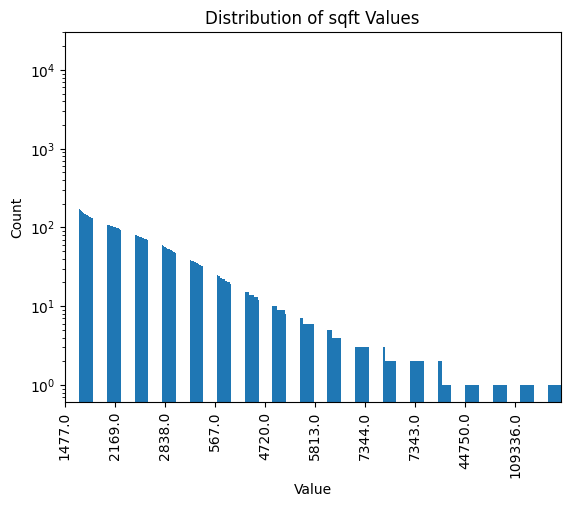

In [129]:
data_2['sqft'].value_counts().plot(kind='bar')
plt.title('Distribution of sqft Values')
plt.xlabel('Value')
plt.ylabel('Count')
plt.yscale('log')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1000))
plt.show()

In [ ]:
# График медианных значений sqft по штатам

fig = go.Figure(data=go.Choropleth(
    locations=States, # list of state abbreviations
    z = list(State_sqft_median_.values()), # values from the dictionary
    locationmode = 'USA-states', # tells plotly to use state abbreviations
    colorscale = 'Reds', # color scheme
    colorbar_title = 'Median sqft'
))

fig.update_layout(
    title_text='Median sqft by State',
    geo_scope='usa' # limits the map to the United States
)

fig.show()

## Обработка признака **beds**

Признак о колличестве койкомест также связан с площадью объекта недвижимости, т.к. существуют типы планировок квартир в зависимости от койкомест.

https://newyorkrealty.us/blog/types-of-apartments-new-york/ - вот информация из интернета.

https://www.crddesignbuild.com/blog/average-bedroom-size - For a typical American home, the average bedroom size is around 132 square feet, perfect for a queen-size bed.

In [149]:
# смотрим значения признака beds, приведенных к нижнему регистру

data_2['beds'] = data_2['beds'].apply(lambda x: x.lower() if isinstance(x, str) else x)
data_2['beds'].unique().tolist()

['4',
 '3 beds',
 '5 beds',
 nan,
 '2 beds',
 '3',
 '4 beds',
 '3 bd',
 'baths',
 '4 bd',
 '5 bd',
 '8 beds',
 '2',
 '2 bd',
 '2.0',
 '5',
 '1',
 '3.0',
 '6 beds',
 'bath',
 '12 beds',
 '6',
 '14',
 '0.25 acres',
 '6 bd',
 '-- bd',
 '7',
 '5.0',
 '4.0',
 ' ',
 '7 beds',
 '1 bd',
 '9 beds',
 '0.44 acres',
 '0',
 '1.43 acres',
 '0.32 acres',
 '8,637 sqft',
 '7.0',
 '8',
 '16 beds',
 '9.7 acres',
 '1.0',
 '16 bd',
 '10,310 sqft',
 '6,250 sqft',
 '3.02 acres',
 '2 acres',
 '5,000 sqft',
 '0.96 acres',
 '6.0',
 '13 bd',
 '6.31 acres',
 '0.6 acres',
 '9',
 '5,662 sqft',
 '2,200 sqft',
 '10',
 '18 beds',
 '10 beds',
 '0.46 acres',
 '0.59 acres',
 '20 beds',
 '0.0',
 '2,874 sqft',
 '0.26 acres',
 '10 bd',
 '32',
 '0.4 acres',
 '2,178 sqft',
 '6,351 sqft',
 '4,356 sqft',
 '5 acres',
 '0.55 acres',
 '5,501 sqft',
 '8,001 sqft',
 '0.7 acres',
 '1.69 acres',
 '0.88 acres',
 '0.34 acres',
 '13 beds',
 '1.5 acres',
 '0.97 acres',
 '7,405 sqft',
 '7 bd',
 '8.43 acres',
 '1,502 sqft',
 '8,712 sqft',
 

In [ ]:
# Смотрим число пропусков в базе

data_2['beds'].nunique()

1184

In [ ]:
# Смотрим распределение уникальных значений в базе

data_2['beds'].value_counts()

beds
3 beds                                                                                                                        53459
4 beds                                                                                                                        35418
3                                                                                                                             31406
2 beds                                                                                                                        26362
4                                                                                                                             20030
2                                                                                                                             16110
baths                                                                                                                         15282
3 bd                                                                   

In [150]:
# Выделяем beds с acre и sqft в своих значениях

Mask_beds_acr_sqft = data_2['beds'][data_2['beds'].apply(lambda x: 'acre' in str(x).lower() or 'sqft' in str(x).lower())]
Mask_beds_acr_sqft = pd.Series(Mask_beds_acr_sqft)
Mask_beds_acr_sqft.value_counts()

beds
-- sqft       97
5,000 sqft    92
1 acre        48
0.34 acres    40
0.28 acres    39
              ..
2.68 acres     1
2.58 acres     1
5,243 sqft     1
8,084 sqft     1
8,479 sqft     1
Name: count, Length: 1037, dtype: int64

In [151]:
Mask_beds_acr_sqft.nunique()

1037

In [152]:
# Выделяем beds с значениями, имеющими сокращенные названия от beds

Mask_beds_bd = data_2['beds'][data_2['beds'].apply(lambda x: 'beds' in str(x).lower() or 'bd' in str(x).lower() or 'bedrooms' in str(x).lower())]
Mask_beds_bd = pd.Series(Mask_beds_bd)
Mask_beds_bd.value_counts()

beds
3 beds                  53459
4 beds                  35418
2 beds                  26362
3 bd                    12877
5 beds                  11271
                        ...  
23 bd                       1
31 beds                     1
20 bd                       1
26 bd                       1
# bedrooms 1st floor        1
Name: count, Length: 82, dtype: int64

In [153]:
Mask_beds_bd.nunique()

82

In [154]:
# Оставшиеся значения beds не содержащие информацию полученную из Mask_beds_acr_sqft и Mask_beds_bd

filtered_beds = data_2['beds'][~data_2['beds'].isin(Mask_beds_acr_sqft) & ~data_2['beds'].isin(Mask_beds_bd)]

filtered_beds.value_counts()

beds
3        31406
4        20030
2        16110
baths    15282
3.0       8088
         ...  
13.0         1
14.0         1
27           1
33           1
35           1
Name: count, Length: 65, dtype: int64

In [155]:
# Преобразуем значения beds в цифровую форму


def process_beds(x):
    x = str(x).lower()
    
    # 1. Если значение столбца приведенное к строковому типу нижнему регистру содержит подстроку 'sqft'
    if 'sqft' in x:
        x = x.replace('sqft', '').replace(' ', '').replace('-', '').replace(',', '.')
        if x:  # проверяем, что строка не пустая
            return float(x)
        else:
            return None  # или любое другое значение по умолчанию
    
    # 2. Если значение столбца приведенное к строковому типу нижнему регистру содержит подстроку 'acre'
    elif 'acre' in x:
        x = x.replace('acre', '').replace('s', '').replace(' ', '').replace(',', '.')
        return float(x) * 43560
    
    # 3. Если значение столбца приведенное к строковому типу нижнему регистру равно '1-2 beds'
    elif x == '1-2 beds':
        return 1.5 * 132
    
    # 4. Если значение столбца приведенное к строковому типу нижнему регистру содержит подстроки 'beds' или 'bd'
    elif 'beds' in x or 'bd' in x:
        x = x.replace('beds', '').replace('bd', '').replace('-', '').replace(' ', '').replace(',', '.')
        if x.endswith('.'):  # проверяем, что строка заканчивается на десятичную точку
            x = x[:-1]  # удаляем последний символ
        if x:  # проверяем, что строка не пустая
            return float(x) * 132
        else:
            return None  # или любое другое значение по умолчанию
    
    # 5. Если значение столбца приведенное к строковому типу нижнему регистру содержит '3 or more bedrooms'
    elif '3 or more bedrooms' in x:
        return 3 * 132
    
    # 6. Если значение столбца приведенное к строковому типу нижнему регистру содержит '2 bedrooms'
    elif '2 bedrooms' in x:
        return 2 * 132
    
    # 7. В оставшихся случаях
    else:
        numstr = '0123456789.'
        x = re.sub('[^' + numstr + ']', '', x)
        if x.endswith('.'):  # проверяем, что строка заканчивается на десятичную точку
            x = x[:-1]  # удаляем последний символ
        if x:  # проверяем, что строка не пустая
            return float(x) * 132
        else:
            return None  # или любое другое значение по умолчанию
    

# создаем новый столбец data['beds_sqft']
data_2['beds_sqft'] = data_2['beds'].apply(lambda x: process_beds(x))

In [156]:
data_2['beds_sqft'][data_2['beds_sqft'] == None].count()

0

In [157]:
data_2['beds_sqft'].isna().sum()

108863

In [158]:
# пропуски заполняем медианным значением

data_2['beds_sqft'] = data_2['beds_sqft'].fillna(data_2['beds_sqft'].median())

In [159]:
print(data_2['beds_sqft'])

0         528.000
1         396.000
2         396.000
3         660.000
4         396.000
           ...   
377180    660.000
377181    396.000
377182    396.000
377183      8.479
377184    396.000
Name: beds_sqft, Length: 377185, dtype: float64


In [245]:
A = data_2['beds_sqft'][data_2['beds_sqft'] < 1.0e+03]

In [246]:
B = data_2['beds_sqft'][data_2['beds_sqft'] >= 1.0e+03]

In [247]:
B.count()

4374

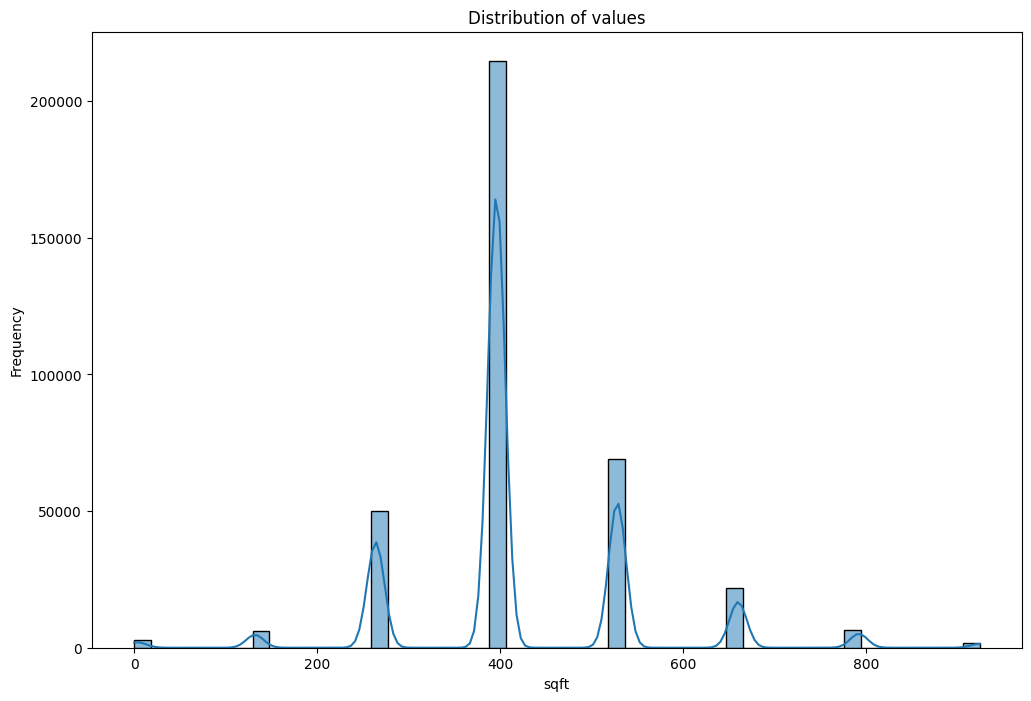

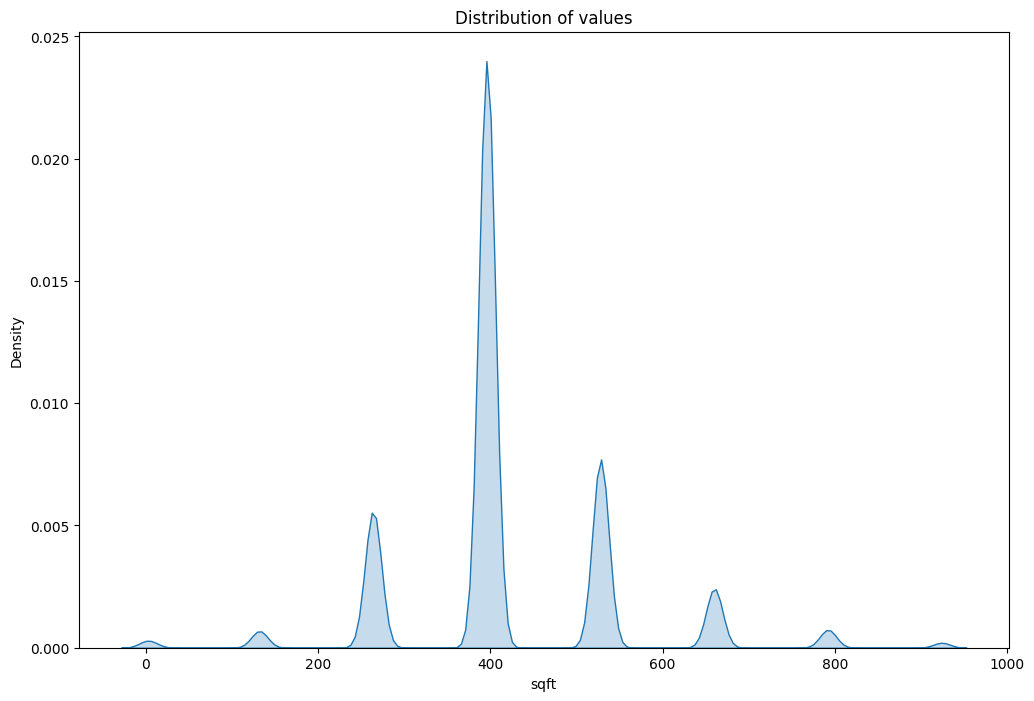

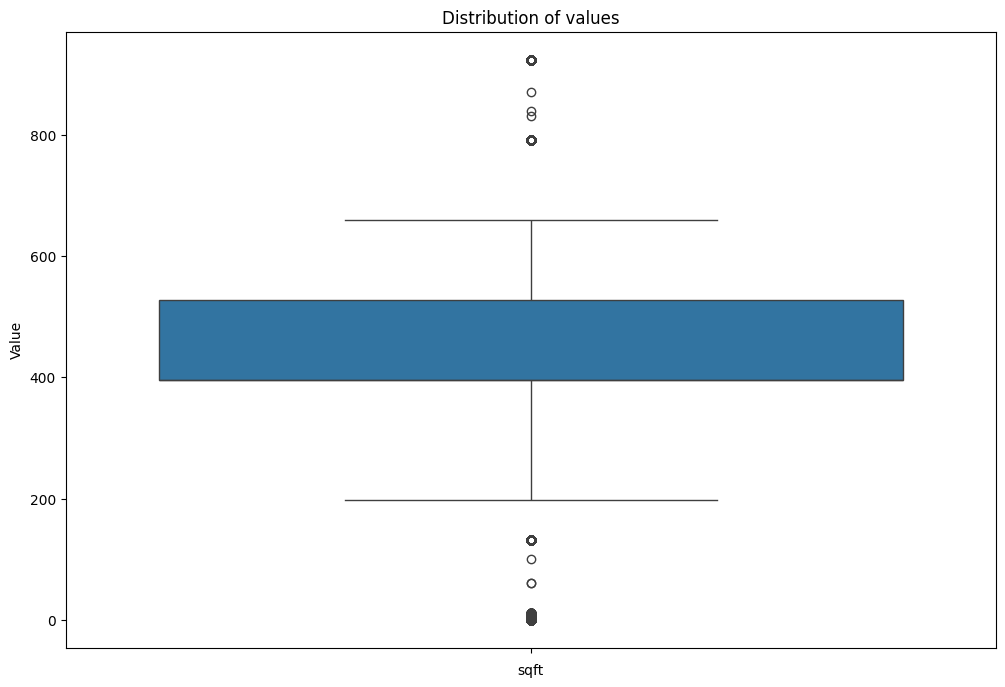

In [ ]:
# Строим график распределения значений

# Histogram
plt.figure(figsize=(12,8))  # Increased size
sns.histplot(A, bins=50, kde=True)
plt.title('Distribution of values')
plt.xlabel('sqft')
plt.ylabel('Frequency')
plt.show()

# Density plot
plt.figure(figsize=(12,8))  # Increased size
sns.kdeplot(A, shade=True)
plt.title('Distribution of values')
plt.xlabel('sqft')
plt.ylabel('Density')
plt.show()

# Boxplot
plt.figure(figsize=(12,8))  # Increased size
sns.boxplot(A)
plt.title('Distribution of values')
plt.xlabel('sqft')
plt.ylabel('Value')
plt.show()

## Изучение признака **stories**

Признак говорит об этажности объекта недвижимости

In [160]:
# Смотрим уникальные значения

data_2['stories'].unique().tolist()

[nan,
 '2.0',
 '1.0',
 '3.0',
 'One',
 '2',
 'Multi/Split',
 '4.0',
 '0.0',
 '0',
 'One Level',
 '1',
 '9.0',
 '3',
 '1 Level, Site Built',
 'One Story',
 '3.00',
 '1.00',
 '14.0',
 'Two',
 '3+',
 '1 Story',
 '5.0',
 '2 Story',
 'Ranch/1 Story',
 'Condominium',
 'Stories/Levels',
 '7.0',
 '2 Level, Site Built',
 '2 Level',
 '15',
 '3 Level, Site Built',
 '4',
 '22.0',
 '2.00',
 '6.0',
 '1.0000',
 'Lot',
 '3 Story',
 'Three Or More',
 '1.5',
 '1 Level',
 'Two Story or More',
 'Site Built, Tri-Level',
 '54.0',
 '23',
 'Farm House',
 '8.0',
 '16.0',
 '1.50',
 '18',
 '9',
 '21',
 '8',
 '12.0',
 'Split Level w/ Sub',
 '11.0',
 '18.0',
 '1.5 Stories',
 '7',
 '11',
 'Townhouse',
 '12',
 '21.0',
 '16',
 '1.5 Story/Basement',
 '28.0',
 'Traditional',
 '2.5 Story',
 '17',
 '2.0000',
 '63.0',
 'Acreage',
 'Ground Level, One',
 '6',
 'Split Foyer',
 '2 Stories',
 '27.0',
 '19.0',
 '2.50',
 '1.30',
 '2 Story/Basement',
 'Split Level',
 '1.5 Story',
 '1.5 Level',
 '2 Or More Stories',
 '1 Level, Con

In [149]:
data_2['stories'].nunique()

347

In [161]:
# Очищаем значения beds от лишних символов и приводим к цифровому виду - целому числу

def clean_string(s):
    s = str(s)
    if isinstance(s, str):
        s = re.sub(r'[^\d\.]', '', s)
        s = re.sub(r'\..*', '', s)
        if s == '':
            return None
        else:
            return int(s)
    else:
        return None

data_2['stories_coding'] = data_2['stories'].apply(clean_string)

In [162]:
data_2['stories_coding'] = pd.to_numeric(data_2['stories_coding'], errors='coerce').fillna(data_2['stories_coding'].median()).astype(int)

In [163]:
Stories_value = data_2['stories_coding'].unique()

In [164]:
# наибольшее число имеют объекты на два койкоместа и одно койкоместо

for i in Stories_value:
    print(f'{i} - {data_2['stories_coding'][data_2['stories_coding'] == i].count()}')

2 - 242225
1 - 95229
3 - 17199
4 - 3119
0 - 11514
9 - 3386
14 - 94
5 - 808
7 - 405
15 - 89
22 - 39
6 - 1012
54 - 8
23 - 51
8 - 335
16 - 119
18 - 59
21 - 73
12 - 160
11 - 116
28 - 26
17 - 87
63 - 5
27 - 30
19 - 69
20 - 105
13 - 81
51 - 6
31 - 28
46 - 21
112 - 5
70 - 12
25 - 46
33 - 41
10 - 75
95 - 2
90 - 6
91 - 4
35 - 24
24 - 43
38 - 19
1234 - 1
26 - 25
30 - 36
36 - 20
42 - 18
45 - 15
29 - 26
55 - 5
78 - 3
56 - 5
47 - 18
34 - 15
40 - 32
43 - 25
80 - 6
32 - 21
57 - 10
41 - 18
39 - 13
64 - 3
48 - 11
58 - 4
52 - 7
37 - 10
50 - 3
44 - 9
68 - 4
60 - 13
77 - 8
233 - 1
75 - 2
66 - 9
62 - 4
82 - 1
49 - 5
1120 - 1
1002 - 1
96 - 1
65 - 1


In [165]:
# Для обїектов больше 2=х средняя этажность четыре

data_2['stories_coding'][data_2['stories_coding'] > 2].count()

c=0
for i in Stories_value:
    if i>2: c+=i

data_2['stories_coding'][data_2['stories_coding'] > 2].count()/c

4.250828562820127

In [166]:
# Перекодируем признак stories_coding в значения до 4-х этажей

data_2['stories_coding'] = data_2['stories_coding'].apply(lambda x: x if x <= 2 else 4)

In [167]:
data_2['stories_coding'].unique()

array([2, 1, 4, 0], dtype=int64)

## Обработка признака **PrivatePool**

Этот признак нам так же дает информацию о наличии или отсутствии бассейна.

In [168]:
# Перекодируем признак в 0 и 1 - нет и есть

data_2['PrivatePool'].unique()

array([nan, 'yes', 'Yes'], dtype=object)

In [169]:
data_2['PrivatePool'][(data_2['PrivatePool'] == 'yes') | (data_2['PrivatePool'] == 'Yes')] = int(1)

In [170]:
data_2['PrivatePool'][data_2['PrivatePool'] == 1].count()

40311

In [171]:
data_2['PrivatePool'] = data_2['PrivatePool'].fillna(int(0)).astype(int)

In [172]:
data_2['PrivatePool'][data_2['PrivatePool'] == 0].count()

336874

In [173]:
data_2['PrivatePool'].isna().sum()

0

## Обработка признаков **mls-id**  и **MlsId**

Эти признаки дают нам информацию о номере риэлтера, совершающего сделку и кода сделки в базе.

In [264]:
data_2['mls-id'].nunique()

24907

In [265]:
data_2['MlsId'].unique().tolist()

['611019',
 '201916904',
 'FR19221027',
 '14191809',
 '861745',
 'PAPH847006',
 'S5026943',
 '10063506',
 '190988',
 '73968331',
 '3087630',
 '5741322',
 'A10767242',
 nan,
 '65299510',
 '3182740',
 'F10207914',
 '4975368',
 '95301365',
 'A10622323',
 'A10786027',
 '13624110',
 '6208631',
 'DCDC448770',
 'A10787617',
 '33856933',
 'A10782357',
 '19-518208',
 'F10174710',
 'A10775650',
 '1027438',
 '3554602',
 '533746',
 'A10743020',
 '14150656',
 'D6107075',
 '190057878',
 'STRI1057289',
 'A10739627',
 '2160520',
 'SR19267193',
 '1310212',
 '5876037',
 '234684',
 '3120965',
 'A10600332',
 '19113987',
 '8688967',
 '1541168',
 '197219',
 'U8048113',
 '8670120',
 '51744683',
 '78774478',
 '6281543',
 '10592240',
 '2160820',
 '21947773',
 '191410',
 '1496191',
 'C7419616',
 '1007253',
 'O5827615',
 '14059831',
 'A10774151',
 '72570155',
 'A10764465',
 '2264748',
 '201925569',
 'A10765877',
 '1424505',
 '995284',
 '14223988',
 'RX-10568210',
 '830642',
 '161411024',
 'O5808438',
 '251980',


In [266]:
data_2['MlsId'].nunique()

232944

Почти на каждую запись в базе приходится уникальное значений - эти признаки нам не дадут полезной информации и мы их удалим.

## Обработка целевого признака **target**

In [267]:
data_2['target']

0           $418,000
1           $310,000
2         $2,895,000
3         $2,395,000
4             $5,000
             ...    
377180    $1,249,000
377181      $674,999
377182      $528,000
377183       $34,500
377184      $204,900
Name: target, Length: 377185, dtype: object

In [174]:
# Отбросим лишние цифровые символы и приведем значения к цифровому типу.

data_2 = data_2[~data_2['target'].astype(str).str.contains('[+/mo]', regex=True)]

In [175]:
data_2['target'] = data_2['target'].str.replace('$', '').str.replace(',', '')

In [176]:
data_2['target'] = data_2['target'].astype(float)

In [166]:
data_2['target'].describe()

count    3.670430e+05
mean     6.494312e+05
std      1.858641e+06
min      1.000000e+00
25%      1.850000e+05
50%      3.200000e+05
75%      5.890000e+05
max      1.950000e+08
Name: target, dtype: float64

In [177]:
data_2['target'].isna().sum()

2481

In [178]:
# Удалим из базы строки с отсутствующими значениями target

data_2.dropna(subset=['target'], inplace=True)

In [179]:
data_2['target'].describe()

count    3.670430e+05
mean     6.494312e+05
std      1.858641e+06
min      1.000000e+00
25%      1.850000e+05
50%      3.200000e+05
75%      5.890000e+05
max      1.950000e+08
Name: target, dtype: float64

График распределения показателей target был смещен влево - поэтому целесообразно работать с прологарифмированными значениями.

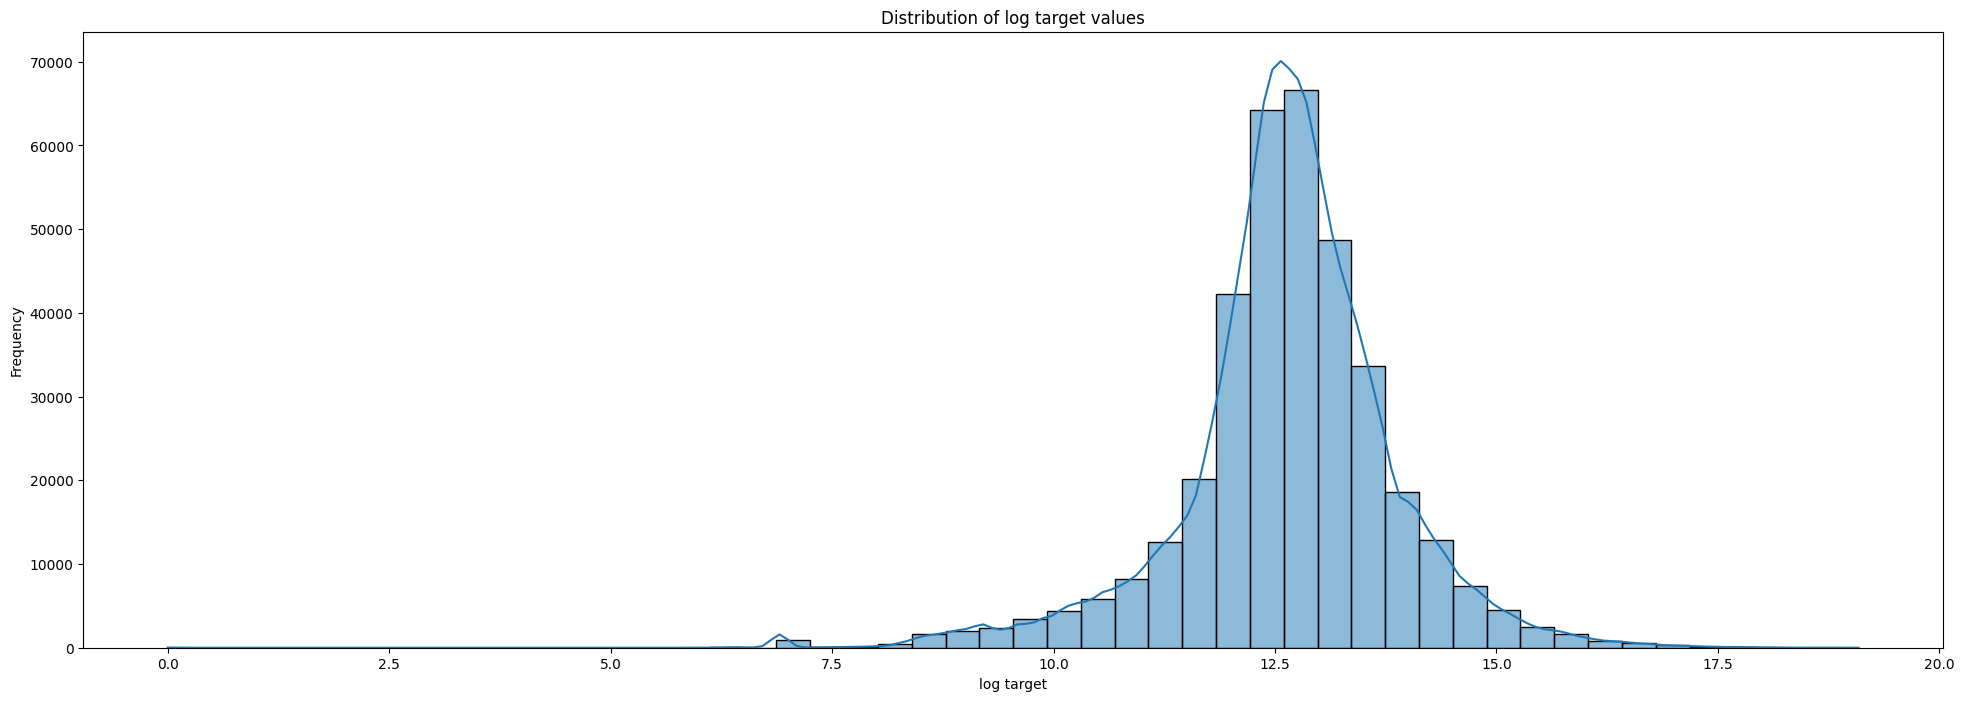

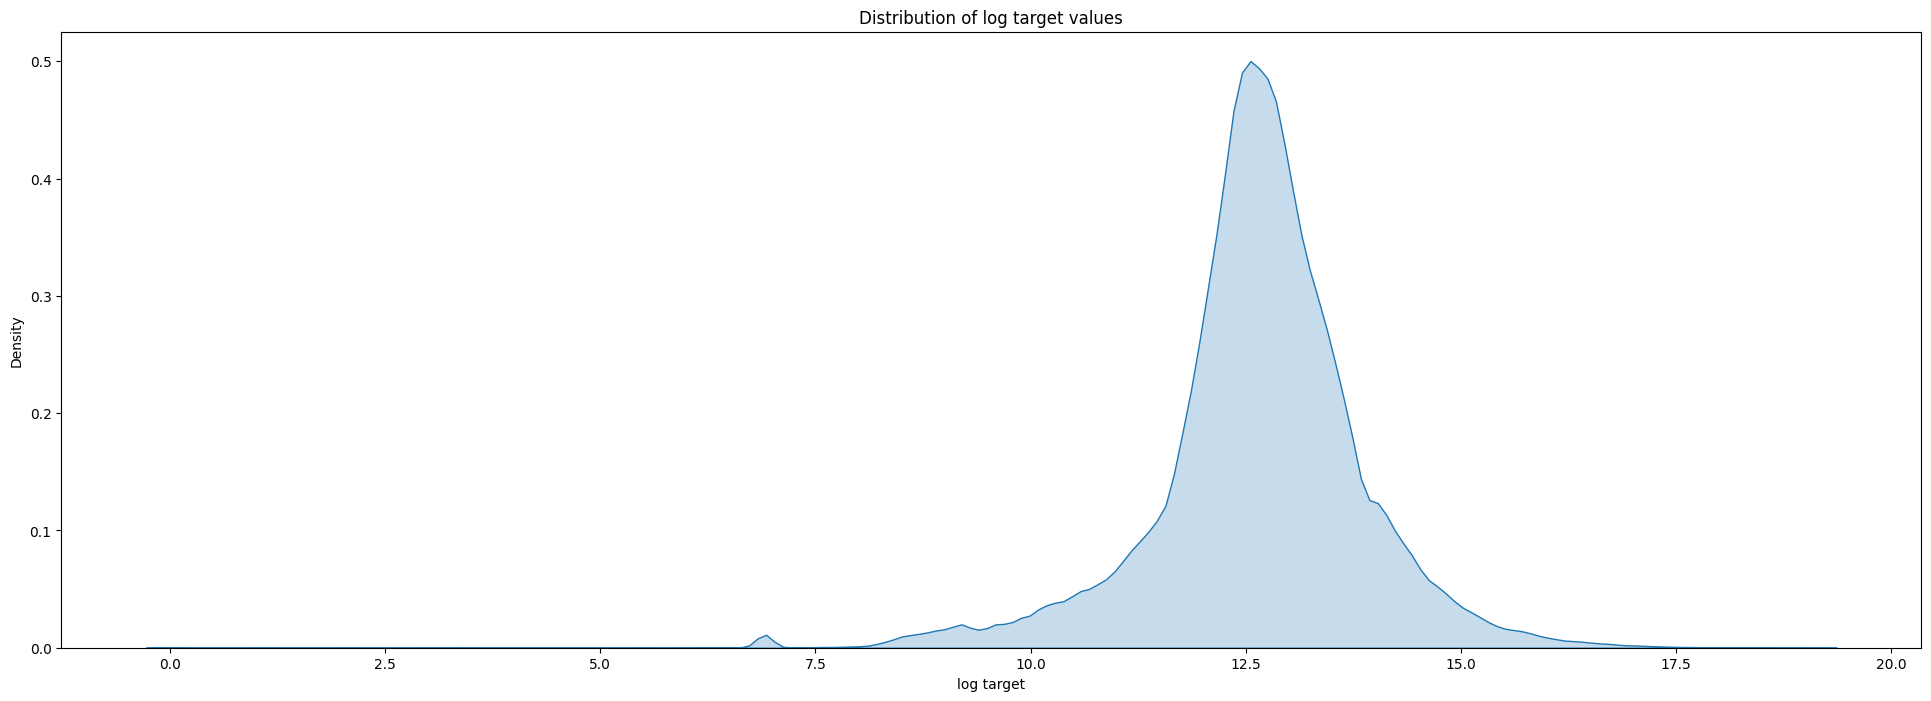

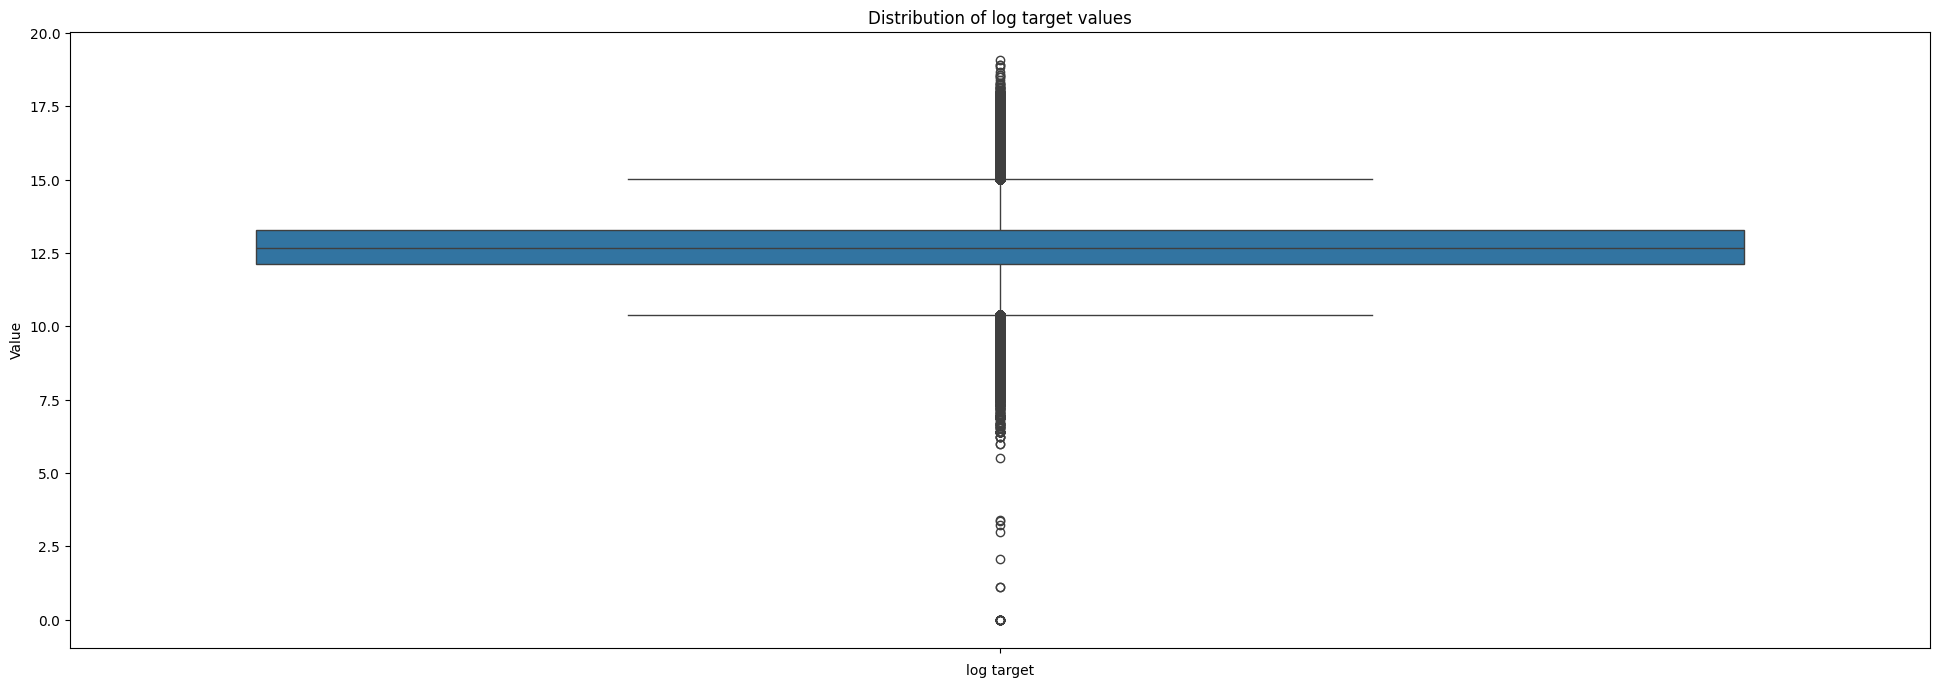

In [170]:
# Histogram
plt.figure(figsize=(24,8))  # Increased size
sns.histplot(np.log(data_2['target']), bins=50, kde=True)
plt.title('Distribution of log target values')
plt.xlabel('log target')
plt.ylabel('Frequency')
plt.show()

# Density plot
plt.figure(figsize=(24,8))  # Increased size
sns.kdeplot(np.log(data_2['target']), shade=True)
plt.title('Distribution of log target values')
plt.xlabel('log target')
plt.ylabel('Density')
plt.show()

# Boxplot
plt.figure(figsize=(24,8))  # Increased size
sns.boxplot(np.log(data_2['target']))
plt.title('Distribution of log target values')
plt.xlabel('log target')
plt.ylabel('Value')
plt.show()

In [180]:
data_2['target_log'] = np.log(data_2['target'])

## Изучение признака **state**

Попробуем сгруппировать штаты по цене квадратного фута.

In [181]:
States = data_2['state'].unique()

State_pricesqft_median = {}

for s in States:
    State_pricesqft_median[s] = data_2['Price/sqft_'][data_2['state'] == s].median()
    
State_pricesqft_median

{'NC': 147.0,
 'WA': 274.0,
 'CA': 417.0,
 'TX': 141.0,
 'FL': 187.0,
 'PA': 166.0,
 'TN': 148.0,
 'IA': 91.0,
 'NY': 410.0,
 'OR': 249.0,
 'DC': 474.0,
 'NV': 182.0,
 'AZ': 153.0,
 'GA': 185.0,
 'IL': 180.0,
 'NJ': 168.5,
 'MA': 495.5,
 'OH': 94.0,
 'IN': 95.0,
 'UT': 202.0,
 'MI': 55.0,
 'VT': 154.0,
 'MD': 238.0,
 'CO': 238.0,
 'VA': 279.0,
 'KY': 68.0,
 'MO': 111.0,
 'WI': 98.0,
 'ME': 95.0,
 'MS': 86.5,
 'OK': 83.0,
 'SC': 140.0,
 'MT': 79.0,
 'DE': 344.0,
 'Fl': 153.0,
 'BA': 29.0,
 'AL': 136.0,
 'OT': 94.0,
 'OS': 114.0}

In [182]:
fig = go.Figure(data=go.Choropleth(
    locations=States, # list of state abbreviations
    z = list(State_pricesqft_median.values()), # values from the dictionary
    locationmode = 'USA-states', # tells plotly to use state abbreviations
    colorscale = 'Reds', # color scheme
    colorbar_title = 'Median price sqft'
))

fig.update_layout(
    title_text='Median price sqft',
    geo_scope='usa' # limits the map to the United States
)

fig.show()

In [183]:
# Для штатов с медианной ценой больше 400 - ставим 4, от 250 до 400 - ставим 3, от 150 до 250 ставим 2, менее 150 ставим 1


def States_coding (State):
    A = State_pricesqft_median[State]
    if A > 400: return 4
    elif A > 250: return 3
    elif A > 150: return 2
    else: return 1

In [184]:
data_2['State_coding'] = data_2['state'].map(States_coding)

In [ ]:
data_2['State_coding'].unique()

array([1, 3, 4, 2], dtype=int64)

In [187]:
Deleted_columns = ['beds','state', 'stories', 'mls-id', 'MlsId', 'target', 'Price/sqft_']

In [188]:
data_2 = data_2.drop(Deleted_columns, axis=1)

In [189]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 367043 entries, 0 to 377184
Data columns (total 82 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   baths                                       367043 non-null  int32  
 1   sqft                                        367043 non-null  float64
 2   PrivatePool                                 367043 non-null  int32  
 3   propertyType_Condo                          367043 non-null  int32  
 4   propertyType_Condo/Townhome/Row Home/Co-Op  367043 non-null  int32  
 5   propertyType_High Rise                      367043 non-null  int32  
 6   propertyType_Land                           367043 non-null  int32  
 7   propertyType_Multi Family                   367043 non-null  int32  
 8   propertyType_Other                          367043 non-null  int32  
 9   propertyType_Single Family Home             367043 non-null  int32  
 10  p

In [190]:
# Строим корелляционную матрицу

Features = data_2.drop(['target_log'], axis=1)

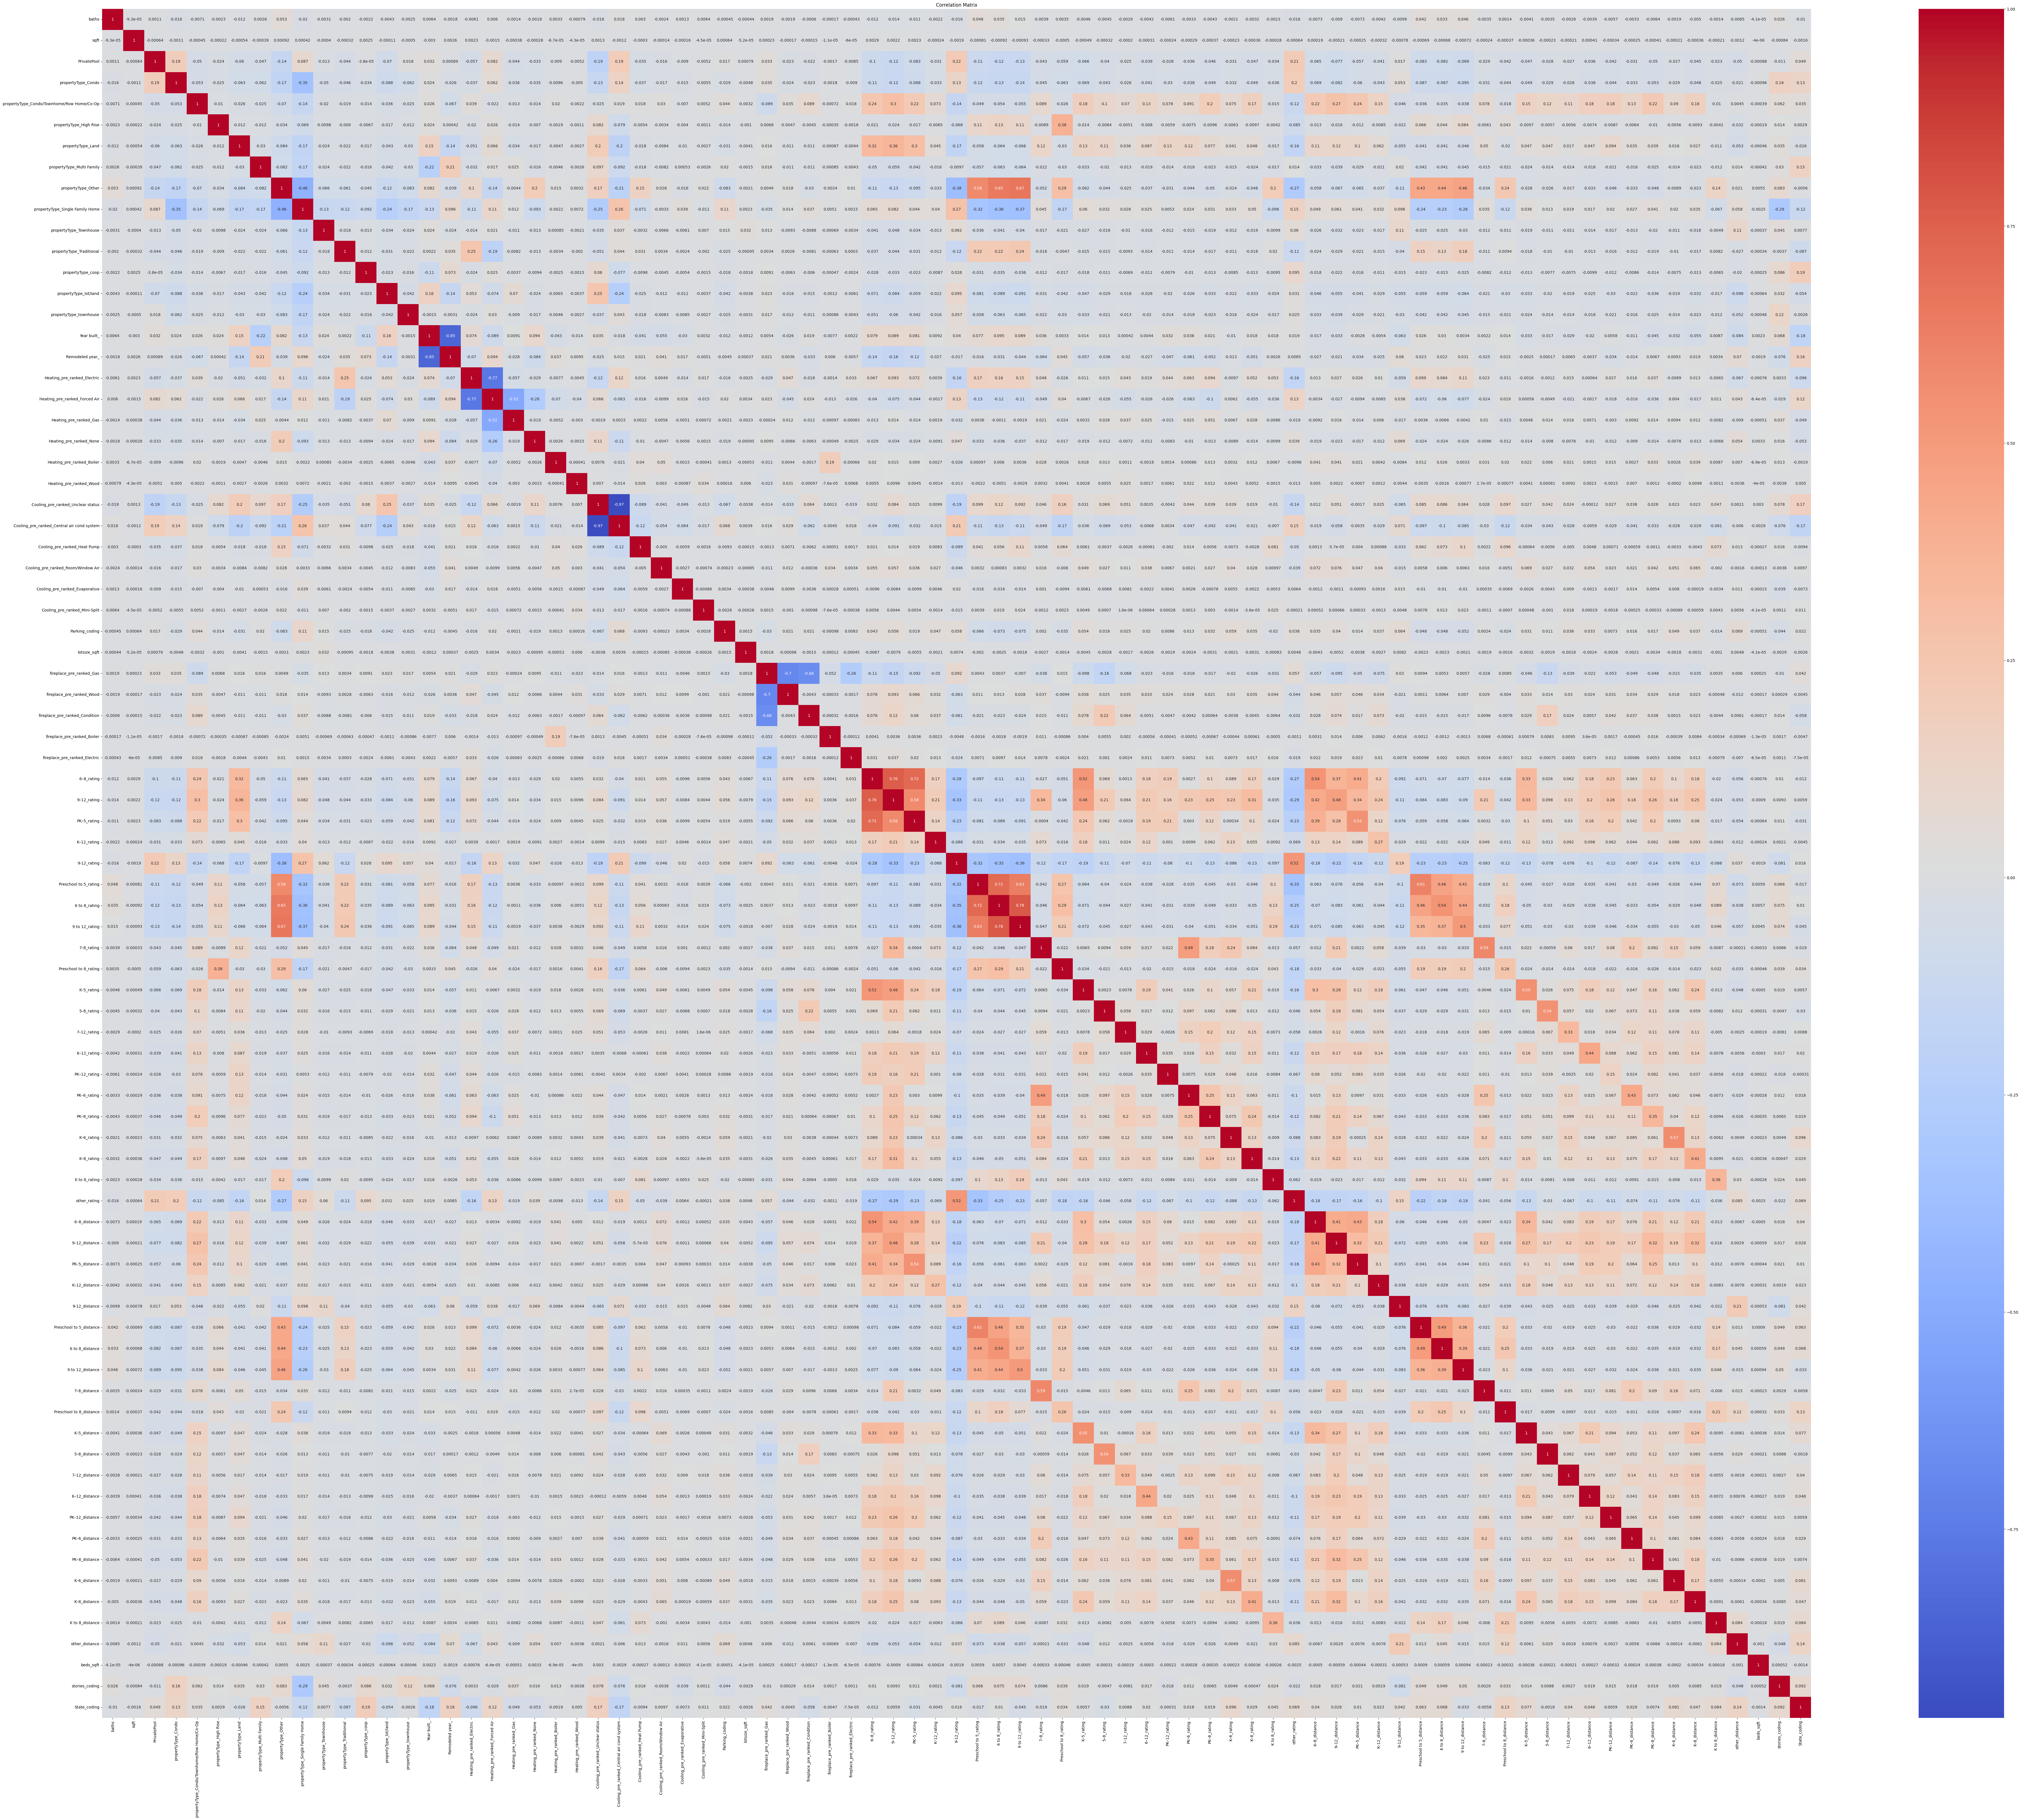

In [191]:
corr_matrix = Features.corr()
plt.figure(figsize=(100, 80))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [192]:
# Признак Cooling_pre_ranked_Unclear status сильно кореллирует с Cooling_pre_ranked_Central air cond system и его целесообразно удалить

data_2 = data_2.drop(['Cooling_pre_ranked_Unclear status'], axis=1)

In [193]:
# Выгружаем обработанные данные в файл для дальнейшей передачи их в модель

data_2.to_csv('Coding_dataset_03.csv', index=False)